# Milestone 2

In [1]:
# Install missing packages
%pip uninstall cpi -y
%pip install cpi

Found existing installation: cpi 1.0.22
Uninstalling cpi-1.0.22:
  Successfully uninstalled cpi-1.0.22
Note: you may need to restart the kernel to use updated packages.
  Using cached cpi-1.0.22-py2.py3-none-any.whl.metadata (1.3 kB)
Using cached cpi-1.0.22-py2.py3-none-any.whl (31.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
#we import all the necessary librairies here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import ast
import cpi


# Make sure that we have the good rate for computing the inflation
cpi.update()


/tmp/ipykernel_13028/71277967.py:10: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  import cpi


In [3]:
#data paths
data_path = './data/'
cmu_path = data_path+'MovieSummaries/'
acl_persona_path = data_path+'ACL_personas_dump/personas/'

## 1. Data cleaning and preprocessing

In this part we will import, clean and transform the data we will use for later analysis.

- We will first create a more complete movie dataset by merging the data from cmu with some useful data from imdb.
- Then, the dataset is cleaned and transformed to be used for later analysis.
- We perform the same cleaning for the character dataset.
- Once all the datasets are ready, we compute a fame score to quantisize the sucess of an actor. This a first version of the fame score that we will show as satisfying enough for the pre-analysis. It will be improved based on futur milestone with more complex computations.
- Finally, we load the dataset from ACL_personas_dump and merge it with the character one to get associate personas to each character.   

#### 1.1 Movie dataset

Let's first have a look at the cmu movie dataset more in details to see what we can do with it.

In [4]:
#Import the cmu movie dataset and print a sample of 5 random row in the dataset
cmu_movie_cols = ['wikiID',
                  'freebase_movID',
                  'movie_name',
                  'release_date',
                  'boxoffice',
                  'runtime',
                  'language',
                  'country',
                  'genre']

cmu_movies = pd.read_csv(cmu_path+'movie.metadata.tsv', sep='\t', names=cmu_movie_cols)
cmu_movies.sample(5)

,wikiID,freebase_movID,movie_name,release_date,boxoffice,runtime,language,country,genre
66963,12178589,/m/02vt1zl,Mother's Day,1980,NaN,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""..."
71596,31427647,/m/0gkykq4,Anubandham,1985-03-29,NaN,NaN,"{""/m/0999q"": ""Malayalam Language""}",{},"{""/m/07s9rl0"": ""Drama""}"
77072,20904503,/m/05b5s_9,Aangan Ki Kali,1979,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/07s9rl0"": ""Drama""}"
397,29513277,/m/0ds31zh,De forældreløse,1917-11-21,NaN,63.0,{},"{""/m/05b4w"": ""Norway""}","{""/m/07s9rl0"": ""Drama""}"
14208,25790377,/m/07yj82k,Mother and Son,1997,NaN,73.0,"{""/m/06b_j"": ""Russian Language""}","{""/m/06bnz"": ""Russia"", ""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci..."


In [5]:
cmu_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wikiID          81741 non-null  int64  
 1   freebase_movID  81741 non-null  object 
 2   movie_name      81741 non-null  object 
 3   release_date    74839 non-null  object 
 4   boxoffice       8401 non-null   float64
 5   runtime         61291 non-null  float64
 6   language        81741 non-null  object 
 7   country         81741 non-null  object 
 8   genre           81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


The first thing we see here is that we do not have a lot of boxoffice data for the movies. However we need a way to asses the success of a movie for our analysis (we will later use this notion to compute a fame score for the actors).

To solve this issue we decided that we will use the imdb rating and number of votes as a proxy for the success and popularity of a movie.

In [6]:
# As the dataset is pretty big, we won't bother importing columns that we don't need later to save memory space
col_to_load = ['tconst','primaryTitle','startYear']
col_dtype = {'tconst': str, 'primaryTitle': str, 'startYear': 'Int64'}

imdb_movies = pd.read_csv(data_path+'title_basics.tsv', usecols=col_to_load, sep='\t', na_values=['\\N'], 
                          dtype=col_dtype)
imdb_ratings= pd.read_csv(data_path+'title_ratings.tsv', sep='\t')

# As this dataset is a way for us to get the title of the rating dataset, we will drop all 
# the rows that have NaN values in the primaryTitle column.
imdb_movies.dropna(subset=['primaryTitle'], inplace=True)

Now let's combine the two to have a new dataset containing the title of the movie and its rating.

In [7]:
imdb_movies_ratings = imdb_movies.merge(imdb_ratings,how='inner',on='tconst')
del imdb_movies
imdb_movies_ratings.sample(5)

,tconst,primaryTitle,startYear,averageRating,numVotes
1177022,tt5595336,Tineke Schouten: Showiesjoo,2001,7.2,7
826334,tt1908788,All 4 One,2011,5.5,25
859375,tt2077719,Bubbleman Superstar Return of Blowfly,2011,6.0,6
508665,tt10984036,Never Happened,2019,5.8,34
325246,tt0631536,A Troubled Image,1963,8.4,28


Now that we have a dataset with the title of the movie and its rating, we can clean the duplicates and the movies with no rating.

In [8]:
imdb_movies_ratings.primaryTitle = imdb_movies_ratings.primaryTitle.str.lower()
imdb_movies_ratings.drop_duplicates(subset=['primaryTitle','startYear'],inplace=True)
imdb_movies_ratings.dropna(subset=['averageRating'], inplace=True)

Now let's merge it to the cmu dataset in order to have a dataset with all the information we need.

In [9]:
#first we lower the title also in the cmu dataset
cmu_movies.movie_name = cmu_movies.movie_name.str.lower()

#then we retrieve the release year of the movies in the cmu dataset
cmu_movies['release_year'] = pd.to_numeric(cmu_movies.release_date.astype(str).str[:4], errors='coerce') \
                               .astype('Int64')
cmu_movies.dropna(subset=['release_year'], inplace=True)

cmu_imdb_movies = cmu_movies.merge(imdb_movies_ratings,left_on=['movie_name','release_year'],
                                                       right_on=['primaryTitle','startYear'])
cmu_movies = cmu_imdb_movies.drop(columns=['primaryTitle','startYear','release_year']).copy()
del imdb_movies_ratings
del cmu_imdb_movies
cmu_movies.sample(5)

,wikiID,freebase_movID,movie_name,release_date,boxoffice,runtime,language,country,genre,tconst,averageRating,numVotes
9720,29816650,/m/0fq2dv2,arjunan saakshi,2011-02-24,NaN,NaN,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/07s9rl0"": ""Drama""}",tt1821329,5.8,373
28356,159447,/m/01510v,the negotiator,1998-07-29,44547681.0,140.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",tt0120768,7.3,152460
8161,26165733,/m/0b6hpz0,the singer not the song,1961,NaN,132.0,{},"{""/m/07ssc"": ""United Kingdom""}","{""/m/07s9rl0"": ""Drama""}",tt0054740,6.2,691
40724,24633376,/m/0806tg_,the effect of gamma rays on man-in-the-moon ma...,1972,NaN,100.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/060__y"": ""Film ada...",tt0068528,7.4,2621
40418,161924,/m/015h0t,kotch,1971-09-17,NaN,114.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0219x_"": ""Indie"", ""/m/07s9rl0"": ""Drama"", ...",tt0067314,6.6,1597


Now that we have all the information we need, we can start working on making the dataset more usable for our analysis.

In [10]:
cmu_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49994 entries, 0 to 49993
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wikiID          49994 non-null  int64  
 1   freebase_movID  49994 non-null  object 
 2   movie_name      49994 non-null  object 
 3   release_date    49994 non-null  object 
 4   boxoffice       7462 non-null   float64
 5   runtime         41919 non-null  float64
 6   language        49994 non-null  object 
 7   country         49994 non-null  object 
 8   genre           49994 non-null  object 
 9   tconst          49994 non-null  object 
 10  averageRating   49994 non-null  float64
 11  numVotes        49994 non-null  int64  
dtypes: float64(3), int64(2), object(7)
memory usage: 4.6+ MB


As we can see here the date are not in a very usable format. We will need to convert them to a datetime format.

In [11]:
cmu_movies['release_date'] = cmu_movies['release_date'].apply(pd.to_datetime)

#we check if we have coherent date
cmu_movies.release_date.describe()

count                            49994
mean     1979-02-19 13:14:03.221186560
min                1888-01-01 00:00:00
25%                1957-02-20 12:00:00
50%                1987-01-01 00:00:00
75%                2003-10-25 00:00:00
max                2016-03-18 00:00:00
Name: release_date, dtype: object

We will now check the distribution of the movies we have through the years. and we will drop the years that have too few movies.

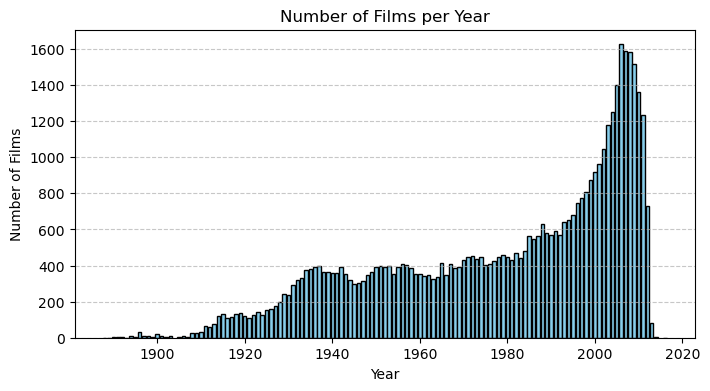

In [12]:
grouped_year = cmu_movies.groupby(cmu_movies.release_date.dt.year).agg(number_films=('movie_name','count')) \
                         .reset_index()

plt.figure(figsize=(8, 4))
plt.bar(grouped_year['release_date'], grouped_year['number_films'], color='skyblue', edgecolor='black')
plt.title('Number of Films per Year')
plt.xlabel('Year')
plt.ylabel('Number of Films')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

It seems the number of movies per year increases with years. Let's see a bit more in details how many years have less than 100, 500, 1000 movies.

In [13]:
# Print the years with less than 100, 500, and 1000 films
years_less_than_100 = grouped_year[grouped_year['number_films'] < 100]['release_date']
years_less_than_500 = grouped_year[grouped_year['number_films'] < 500]['release_date']
years_less_than_1000 = grouped_year[grouped_year['number_films'] < 1000]['release_date']

print(f'Number of years with less than 100 films: {len(years_less_than_100)}')
print(f'Number of years with less than 500 films: {len(years_less_than_500)}')
print(f'Number of years with less than 1000 films: {len(years_less_than_1000)}')

# Print the year with the max number of movies
max_films_year = grouped_year.loc[grouped_year['number_films'].idxmax(), 'release_date']
max_films_count = grouped_year['number_films'].max()
print(f'The year with the max number of films is: {max_films_year:.0f} with {max_films_count} films')

Number of years with less than 100 films: 28
Number of years with less than 500 films: 99
Number of years with less than 1000 films: 117
The year with the max number of films is: 2006 with 1625 films


We see that there are not that much years with less than 100 movies. We will drop them from our dataset, in order to have more significant results when we will do year based analysis.

In [14]:
# In the original CMU dataset remove the rows with release year with less than 100 films
years_to_remove = grouped_year[grouped_year['number_films'] < 100]['release_date'].tolist()
cmu_movies = cmu_movies[~cmu_movies.release_date.dt.year.isin(years_to_remove)].copy()

We have also the problem that so far the values in the columns 'language', 'country' and 'genre' are still in a object format and not easily usable. We will need to convert them to a more usable format. For an easy access to those values later we will interpret them as dictionaries that we'll convert to a list format since we do not need the keys (that come from freebase).

In [15]:
# Transform the object dtype into list of values:
# We use ast.literal_eval to interpret the string as a dictionnaries, we take only their values and 
# we convert it to a list
cmu_movies['language'] = cmu_movies['language'].apply(lambda x: list(ast.literal_eval(x).values())) 
cmu_movies['country'] = cmu_movies['country'].apply(lambda x: list(ast.literal_eval(x).values()))
cmu_movies['genre'] = cmu_movies['genre'].apply(lambda x: list(ast.literal_eval(x).values()))

# Check the max number of values in each list(i.e. the max number of languages, countries and genres for a movie)
print(f'The max number of values in a single list for language is {cmu_movies["language"].apply(len).max()}')
print(f'The max number of values in a single list for country is {cmu_movies["country"].apply(len).max()}')
print(f'The max number of values in a single list for genre is {cmu_movies["genre"].apply(len).max()}')

The max number of values in a single list for language is 11
The max number of values in a single list for country is 14
The max number of values in a single list for genre is 17


In [16]:
# Cleaned version of the CMU dataset
cmu_movies

,wikiID,freebase_movID,movie_name,release_date,boxoffice,runtime,language,country,genre,tconst,averageRating,numVotes
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",tt0228333,4.9,57038
1,28463795,/m/0crgdbh,brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",tt0094806,5.6,42
2,9363483,/m/0285_cd,white of the eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",tt0094320,6.1,2911
3,261236,/m/01mrr1,a woman in flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama],tt0083949,5.9,623
5,10408933,/m/02qc0j7,alexander's ragtime band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",tt0029852,6.8,2277
...,...,...,...,...,...,...,...,...,...,...,...,...
49989,15394941,/m/03m6zh4,gopi kishan,1994-12-02,NaN,NaN,[Hindi Language],[India],"[Drama, Action, Crime, Comedy]",tt0109922,5.8,972
49990,23851782,/m/06_vb43,the ghost train,1941-05-03,NaN,82.0,[English Language],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]",tt0033660,6.2,1588
49991,35228177,/m/0j7hxnt,mermaids: the body found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama],tt1816585,4.6,1711
49992,34980460,/m/0g4pl34,knuckle,2011-01-21,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",tt1606259,6.8,3203


In [17]:
cmu_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49477 entries, 0 to 49993
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   wikiID          49477 non-null  int64         
 1   freebase_movID  49477 non-null  object        
 2   movie_name      49477 non-null  object        
 3   release_date    49477 non-null  datetime64[ns]
 4   boxoffice       7461 non-null   float64       
 5   runtime         41685 non-null  float64       
 6   language        49477 non-null  object        
 7   country         49477 non-null  object        
 8   genre           49477 non-null  object        
 9   tconst          49477 non-null  object        
 10  averageRating   49477 non-null  float64       
 11  numVotes        49477 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(6)
memory usage: 4.9+ MB


We see here that we have enough data for our analysis.

#### 1.2 Characters dataset

Now that we have a usable and clean dataset for the movies we will interest ourselves in the character dataset. To do that let first have a look at the dataset.

In [18]:
cmu_character_cols = ['wikiID',
                      'freebase_movID',
                      'release_date',
                      'character_name',
                      'actor_birth',
                      'actor_gender',
                      'actor_height',
                      'actor_ethnicity',
                      'actor_name',
                      'actor_age_at_release',
                      'freebase_char_actor_map',
                      'freebase_charID',
                      'freebase_actorID']

cmu_character = pd.read_table(cmu_path+'character.metadata.tsv', names=cmu_character_cols)
cmu_character.sample(5)

,wikiID,freebase_movID,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID
15471,1745419,/m/05spx3,1995-10-04,NaN,1938-08-29,M,1.91,/m/041rx,Elliott Gould,57.0,/m/03jrn4b,NaN,/m/02xwgr
297084,2641298,/m/07tqdy,1994-02-11,NaN,1920-09-01,M,1.83,NaN,Richard Farnsworth,73.0,/m/0cf_v95,NaN,/m/017115
182017,8279721,/m/026yttf,1949,NaN,1908-11-04,M,NaN,NaN,Anthony Warde,40.0,/m/09h_gr6,NaN,/m/04gv_2p
369502,34129784,/m/09pghcp,1941-12,Dotty,1916-03-25,F,NaN,NaN,Jean Rogers,NaN,/m/0hpgdxm,/m/0hpgdxq,/m/07f5ms
356486,22895245,/m/063_x6l,1929-10-25,Girl,1909-08-06,F,NaN,NaN,Alice Adair,20.0,/m/0n1vyfb,/m/0n1vyff,/m/0gghpm4


In [19]:
cmu_character.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   wikiID                   450669 non-null  int64  
 1   freebase_movID           450669 non-null  object 
 2   release_date             440674 non-null  object 
 3   character_name           192794 non-null  object 
 4   actor_birth              344524 non-null  object 
 5   actor_gender             405060 non-null  object 
 6   actor_height             154824 non-null  float64
 7   actor_ethnicity          106058 non-null  object 
 8   actor_name               449441 non-null  object 
 9   actor_age_at_release     292556 non-null  float64
 10  freebase_char_actor_map  450669 non-null  object 
 11  freebase_charID          192804 non-null  object 
 12  freebase_actorID         449854 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 44.7+ MB


We will first drop any null value we have on the wikiID column or in the freebase_actorID column since we don't want character without actor or movie, we also drop the dupplicates if we have more than one character for the same actor in the same movie.

In [20]:
cmu_character.dropna(subset=['wikiID','freebase_actorID'], inplace=True)
cmu_character.drop_duplicates(subset=['wikiID','freebase_actorID'], inplace=True)

We will now create a dataset containing the information about the actors and the movies they played in.

In [21]:
actor_movie = cmu_character.drop(columns='release_date', axis=1) \
                           .merge(cmu_movies[['wikiID','averageRating','numVotes','release_date','tconst']],
                                  on='wikiID',how='inner')
actor_movie.head(5)

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,averageRating,numVotes,release_date,tconst
0,975900,/m/03vyhn,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,4.9,57038,2001-08-24,tt0228333
1,975900,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,4.9,57038,2001-08-24,tt0228333
2,975900,/m/03vyhn,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,4.9,57038,2001-08-24,tt0228333
3,975900,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,4.9,57038,2001-08-24,tt0228333
4,975900,/m/03vyhn,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,4.9,57038,2001-08-24,tt0228333


In [22]:
# We also add the principal actors for each movie
imdb_principals = pd.read_csv(data_path+'name_principals.csv')
imdb_principals.primaryName  = imdb_principals.primaryName.str.lower()
imdb_principals['is_principal'] = 1

actor_movie = actor_movie.merge(imdb_principals,
                                how="left",
                                left_on=['tconst',actor_movie.actor_name.str.lower()],
                                right_on=['tconst','primaryName']).drop(columns=['tconst','primaryName'])
actor_movie['is_principal'].fillna(0, inplace = True)

del imdb_principals
cmu_character = actor_movie.drop(columns=['averageRating','numVotes']).copy()
cmu_character

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,release_date,is_principal
0,975900,/m/03vyhn,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001-08-24,0.0
1,975900,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001-08-24,0.0
2,975900,/m/03vyhn,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001-08-24,1.0
3,975900,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001-08-24,1.0
4,975900,/m/03vyhn,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001-08-24,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331172,9971909,/m/02pygw1,NaN,1938-11-26,M,NaN,NaN,Rich Little,33.0,/m/02vbk4r,NaN,/m/03m6t5,1972-09-22,1.0
331173,9971909,/m/02pygw1,NaN,1918-10-02,M,NaN,NaN,Herb Voland,53.0,/m/0ggdv2_,NaN,/m/02qylb9,1972-09-22,1.0
331174,28308153,/m/0cp05t9,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44,1957-01-01,1.0
331175,28308153,/m/0cp05t9,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,1957-01-01,0.0


We will now compute a fame score for each actor basing ourselves on the three previous movies he played in to have for every actor a first carreer success indicator. This is subject to change but for the 2nd milestone this first version of the fame score is satisfying (we will show this later on).

We first define a function to compute this fame score and then we apply it to our dataset. 

The function follows this reasoning:
- A fame score should be high if a movie as a high rating and a high number of votes (we limit the impact of the number of votes by taking its log value). 
- The impact of previous movies should be mitigated by the time since the movie was released.

We will detail in the second part of this milestone why this fame score is satisfying for the pre-analysis.

In [23]:
def fame_score(row,data):
    ''' 
    This function computes the fame score of an actor based on the average rating and the number of votes of the 
    3 past movies, if they exist.
    '''

    n = row['index']
    rowm1 = data.iloc[n-1]
    rowm2 = data.iloc[n-2]

    actor = row['freebase_actorID']
    year = row['release_date'].year
    rate = row['averageRating']
    votes = row['numVotes']

    fame_score = rate * np.log(votes) / (year-1700)

    if rowm2['freebase_actorID'] == actor:
        year = rowm2['release_date'].year
        rate = rowm2['averageRating'] 
        votes = rowm2['numVotes']
        fame_score += rate * np.log(votes) / (year-1700)

    if rowm1['freebase_actorID'] == actor:
        year = rowm1['release_date'].year
        rate = rowm1['averageRating']
        votes = rowm1['numVotes']
        fame_score += rate * np.log(votes) / (year-1700)

    return fame_score

In [24]:
def instant_fame_score(row,data):
    year = row['release_date'].year
    rate = row['averageRating']
    votes = row['numVotes']
    is_principal = row['is_principal']

    instant_fameScore = rate * np.sqrt(votes) / (year-1900) * (1 + 0.2*is_principal)

    return instant_fameScore

actor_movie.sort_values(by=['freebase_actorID','release_date'], inplace=True)
actor_movie['instant_fameScore'] = actor_movie.apply(lambda x: instant_fame_score(x,actor_movie), axis=1)

In [25]:
def get_fame_score(df, mode='before_after_films'):
    df = df.sort_values('release_date')

    dates = df['release_date'].to_numpy()
    if mode=='filmography':
        # every day between first and last films
        time_range = pd.date_range(dates[0], dates[-1], freq='D').to_list()
    elif mode=='before_after_films':
        # day before and release date of films
        time_range = np.hstack(list(map(lambda d: [d-pd.Timedelta(days=1),d-pd.Timedelta(days=0)], dates)))
    
    # make time_range non decreasing against cases with two films on the same day
    time_range = np.maximum.accumulate(time_range)
    #create a time_range for each films
    time_ranges = np.expand_dims(time_range, axis=0).repeat(axis=0,repeats=len(dates))
    #convert each time range to the number of days from film release date
    day_deltas = np.array(list(map(lambda x : list(map(lambda y,z: (y - dates[z]).days, x[1], [x[0]]*len(time_range))), enumerate(time_ranges))))
    # get exponential for each film
    exps = np.array(list(map(lambda x: np.exp(-x/4/365/5), day_deltas))) # CAN CHANGE DECAY HERE

    # mask exponential part before film release, treated in two cases to deal with films released on the same day issue
    if mode=='filmography':
        exps[exps>1] = 0
    elif mode=='before_after_films':
        idx = np.indices(exps.shape)
        mask = idx[1]<2*idx[0]+1
        exps[mask] = 0
    
    exps = np.diag(df['instant_fameScore'])@exps # CAN CHANGE SCALING HERE

    return time_range, exps.max(axis=0)

def fame_score(df, mode='before_after_films'):
    if mode=='filmography':
        return get_fame_score(df, mode='filmography')
    elif mode=='before_after_films':
        _, fame_scores = get_fame_score(df)
        df['fameScore_before']=fame_scores[2*np.arange(len(fame_scores)//2)]
        df['fameScore_after']=fame_scores[2*np.arange(len(fame_scores)//2)+1]
        return df

In [26]:
actor_movie = actor_movie.groupby('freebase_actorID').apply(fame_score).reset_index(drop=True)
actor_movie['fameScore']=actor_movie['fameScore_after']

# We drop the columns we don't need anymore
cmu_character = actor_movie.drop(columns=['averageRating','numVotes']).copy()
del actor_movie
cmu_character.sample(5)

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,release_date,is_principal,instant_fameScore,fameScore_before,fameScore_after,fameScore
168454,22015467,/m/05p8ddl,Meet,1970-12-03,M,1.79,/m/0dryh9k,Jimmy Shergill,38.0,/m/062wq_w,/m/0h36mmd,/m/075r_k,2009-04-10,0.0,0.763512,20.764570,20.761726,20.761726
320712,14628494,/m/03gr5mh,NaN,1891-12-25,M,NaN,NaN,Earle Fox,NaN,/m/08pzc3p,NaN,/m/0krwhp,1916-02-13,0.0,2.405268,6.222029,6.221177,6.221177
229278,27122422,/m/0bdq3hj,Quinny,1970-10-15,M,1.85,NaN,Zak Orth,39.0,/m/0bdq574,/m/0bdq54n,/m/0cg65w,2010-04-24,1.0,1.607009,30.787597,30.783380,30.783380
50485,3156200,/m/08w0v1,NaN,1924-07-19,M,1.78,NaN,Pat Hingle,44.0,/m/03jt5ms,NaN,/m/02dztn,1968-07-31,1.0,25.325940,16.108130,25.325940,25.325940
10887,240962,/m/01jzbz,NaN,1961-08-09,F,NaN,NaN,Amy Stiller,38.0,/m/0lnsvxb,NaN,/m/0194r1,2000-01-01,0.0,0.361497,22.254728,22.251680,22.251680


Now that we a cleaned dataset of character with the corresponding fame score of each actor, we would like that have more information on the character the actor is playing in this movie. For that we will use the persona dataset to be able later to understand the relation between the character and the actor. 

In [27]:
acl_persona_cols = ['entity_id',
                    'wikiID',
                    'movie_name',
                    'entity_name',
                    'full_entity_name',
                    'entity_num_event',
                    'persona',
                    'final_posterior']

acl_persona = pd.read_table(acl_persona_path+'25.100.lda.log.txt', header=None, names=acl_persona_cols)
acl_persona.sample(5)

,entity_id,wikiID,movie_name,entity_name,full_entity_name,entity_num_event,persona,final_posterior
66425,/m/06494m7,22933412,Grown Ups,Rob Hilliard,his,8,18,0.00000 0.01000 0.01000 0.00000 0.00000 0.0600...
108546,/m/05tftqx,31969018,Ishq Unplugged,Sameer,Sameer and Sanjana,16,3,0.00000 0.00000 0.00000 0.94000 0.00000 0.0000...
129736,e9,42093,Gentleman's Agreement,it,it,3,23,0.00000 0.02000 0.05000 0.10000 0.00000 0.0200...
143305,e13,5541106,Spider Forest,he,his,6,21,0.00000 0.00000 0.01000 0.00000 0.00000 0.0000...
158319,e1,7133888,The Lost Patrol,sergeant,the Sergeant,7,35,0.00000 0.00000 0.00000 0.00000 0.00000 0.0000...


We want now to populate our cmu_character dataframe with those informations about the personas.

In [28]:
cmu_character = cmu_character.merge(acl_persona[['entity_id','persona']], 
                                    left_on='freebase_char_actor_map', 
                                    right_on='entity_id', how='left').drop(columns='entity_id')
del acl_persona
# Print the final dataset
cmu_character

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,release_date,is_principal,instant_fameScore,fameScore_before,fameScore_after,fameScore,persona
0,26147476,/m/0b6jfrc,Mike's Stupid Boss,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,34.0,/m/0gy5tc8,/m/0gy5tcb,/m/010p3,1999-01-01,0.0,3.616613,0.000000,3.616613,3.616613,NaN
1,4209429,/m/0bq2wj,NaN,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,35.0,/m/0h41kvc,NaN,/m/010p3,2000-01-01,0.0,4.557316,3.440700,4.557316,4.557316,NaN
2,20619519,/m/051wrdv,NaN,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,35.0,/m/0cvctbl,NaN,/m/010p3,2000-01-01,0.0,1.320426,4.557316,4.557316,4.557316,NaN
3,2981197,/m/08hjr9,'The Man Show' Host,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,35.0,/m/0gy5t9q,/m/0gy5t9s,/m/010p3,2000-01-21,0.0,6.244998,4.545470,6.244998,6.244998,NaN
4,7197477,/m/0kv065,NaN,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,38.0,/m/03lsx30,NaN,/m/010p3,2003-01-01,0.0,3.334397,5.389866,5.389128,5.389128,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331186,31024173,/m/0gg5qcw,Tom Duffy,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,44.0,/m/0gk8xfg,/m/0gvdm_6,/m/0zcbl,2011-08-31,1.0,36.702092,55.150459,55.142904,55.142904,2.0
331187,30431590,/m/0h33rzv,Arnie,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,44.0,/m/0n3ypdx,/m/0hgfgdz,/m/0zcbl,2012-01-23,1.0,13.487507,54.065812,54.058406,54.058406,NaN
331188,31734473,/m/0gtvrv3,Benno Levin,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,44.0,/m/0bvdd_d,/m/0h27z5r,/m/0zcbl,2012-05-25,0.0,10.142921,53.162472,53.155190,53.155190,NaN
331189,31306385,/m/0gj8t_b,Paul Gill,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,45.0,/m/0gljb0n,/m/0gwg8hc,/m/0zcbl,2012-06-15,0.0,14.988049,53.009759,53.002497,53.002497,49.0


In [29]:
cmu_character.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331191 entries, 0 to 331190
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   wikiID                   331191 non-null  int64         
 1   freebase_movID           331191 non-null  object        
 2   character_name           151500 non-null  object        
 3   actor_birth              255838 non-null  object        
 4   actor_gender             299259 non-null  object        
 5   actor_height             122677 non-null  float64       
 6   actor_ethnicity          80723 non-null   object        
 7   actor_name               330897 non-null  object        
 8   actor_age_at_release     225115 non-null  float64       
 9   freebase_char_actor_map  331191 non-null  object        
 10  freebase_charID          151505 non-null  object        
 11  freebase_actorID         331191 non-null  object        
 12  release_date    

In [30]:
ethnicity_map = pd.read_table(data_path+'ethnicities_data.tsv', sep='\t', index_col=0).to_dict()['Ethnicities']
cmu_character['actor_ethnicity'] = cmu_character['actor_ethnicity'].map(ethnicity_map)
ethnicity_map = pd.read_table(data_path+'ethnicity_group_data.tsv', sep='\t', index_col=0).to_dict()['Ethnic Group']
cmu_character['actor_ethnicity'] = cmu_character['actor_ethnicity'].map(ethnicity_map)

## 2. First Data analysis

In the first part we will try to confirm if the fame score is a good indicator of the success of an actor.

Then we will start looking at the impact of different variables on the fame score in order to have a first glimpse at the way to succeed for an actor. This will allow us to assess the relevance of our problematic.

### 2.1 Relation between Box Office, Ratings, and Votes

For the moment we assumed that we could use the ratings as a proxy for the success of a movie. We will now try to see if this assumption is correct (if the ratings are correlated with the box office).

First we clean the cmu_movies to remove rows where either rating or boxoffice is missing.

In [31]:
#Remove rows where both boxoffice and rating are missing
movies_df = cmu_movies.dropna(subset=['boxoffice','averageRating']).copy()

Before doing any analysis we will also adjust the boxoffice to take into account the inflation (i.e., values will be in 2020 dollars)

In [32]:
movies_df["adj_boxoffice"] = movies_df.apply(lambda x: cpi.inflate(x["boxoffice"], x.release_date.year, to=2020), axis=1)

Let's now plot the boxoffice and the ratings taking into account the number of votes and the year of the movie, to see if there is any noticeable relation between those variables.

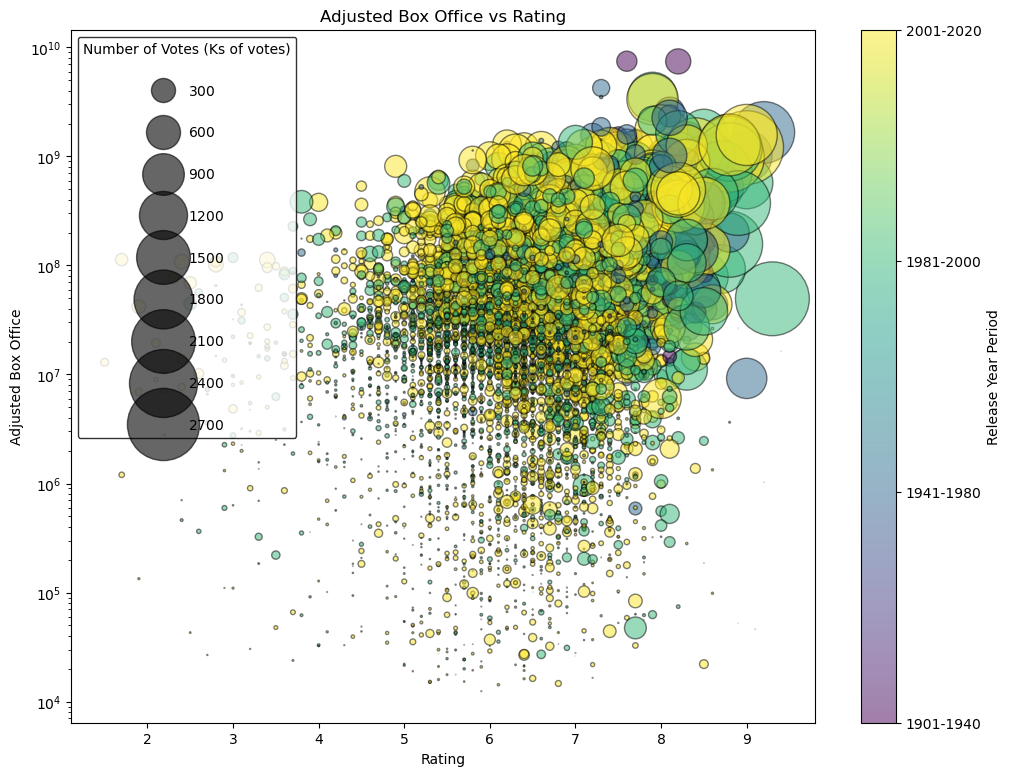

In [33]:
# Divide data into 4 different time periods
periods = [(1901, 1940), (1941, 1980), (1981, 2000), (2001, 2020)]

plt.figure(figsize=(12,9))

# Scatter plot with size based on 'numVotes' and color based on time periods
scatter = plt.scatter(movies_df['averageRating'], movies_df['adj_boxoffice'], 
                      s=movies_df['numVotes']/1000, alpha=0.5, edgecolors='black', 
                      c=np.digitize(movies_df.release_date.dt.year, bins=[period[0] for period in periods[1:]]), 
                      cmap='viridis')


plt.title('Adjusted Box Office vs Rating')
plt.xlabel('Rating')
plt.ylabel('Adjusted Box Office')
plt.yscale('log')

# Create custom legend using legend_elements for sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
legend = plt.legend(handles, labels, loc="upper left", title="Number of Votes (Ks of votes)", 
                    frameon=True, labelspacing=2)

# Set the edge color of the legend frame
legend.get_frame().set_edgecolor('black')

# Create a colorbar to show time periods
cbar = plt.colorbar(scatter, ticks=np.arange(len(periods)), label='Release Year Period')
cbar.set_ticklabels([f'{start}-{end}' for (start, end) in periods])

plt.show()

From this plot we can derive several informations:

- Films with high number of votes tend to have high ratings and high boxoffice. This is not surprising since the more people watch a movie, the more likely it is to be good and to have a high boxoffice.
- The boxoffice seems to be higher with years.
- Films with low rating tend to have lower number of votes. Is it because people don't watch them based on their low ratings.

We will look at the correlation matrix to have a better understanding at the potential correlation we could find between the variables.

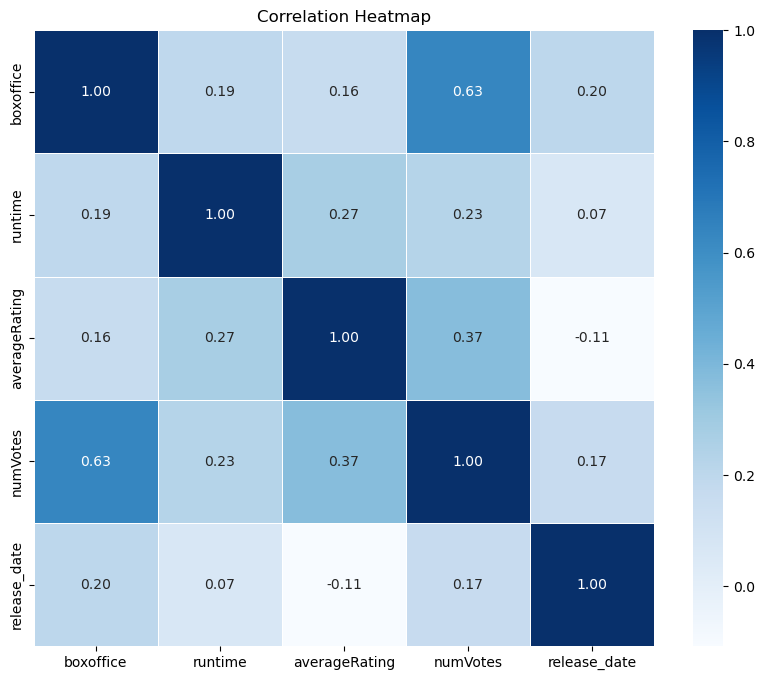

In [34]:
# Calculate the correlation matrix
correlation_matrix = movies_df[['boxoffice', 'runtime', 'averageRating', 'numVotes', 'release_date']]\
                              .corr(method='pearson')

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

This tends to show that the rating and the boxoffice are not correlated. However We have a big correlation between the number of votes, the boxoffice and the rating. 

We confirmed the fact that the more a film is voted the more it tends to have a high rating and a high boxoffice. As we use in the fame score the rating * log(number of votes) we can assume as a first approximation that we capture well the success of a movie an actor plays in and thus the fame of the actor gained thanks to this movie. 

The fact that we explicitly use the rating combined with the number of votes has the effect to give more fame to an actor that plays in "good" movies, movies with high ratings (it is more important for an actor to play in a good movie than in a bad one even if the bad one can sometime bring more money (bigger boxoffice)).

### 2.2 Feats Analysis

We will start by digging into the impact of other actors on your own fame. Casting a movie with a celebrity may bring light on a rising star and contribute to its success. For example, in the plots below, to what extent did Andy Serkis playing Gollum in the Lord of the Rings benefitted in fame from playing with Cate Blanchett, as Galadriel, in that movie knowing that Cate Blanchett has a fame score among the 100 best ones in previous years.

In [35]:
def plot_filmography(actor_name):
    '''
    This function plots the fame score of an actor along the years and the movies he played in
    '''
    
    filmography = cmu_character.query(f"actor_name=='{actor_name}'").sort_values('release_date')
    filmography = filmography.merge(cmu_movies[['wikiID','movie_name']], on='wikiID')
    
    plt.figure(figsize=(10,5))
    for i,film in filmography.iterrows():
        plt.scatter(film.release_date, film.fameScore, label=str(i+1)+' : '+film.movie_name,
                    color='cornflowerblue')
        plt.annotate(i+1, xy=(film['release_date'],film['fameScore']), xytext=(4,0), textcoords='offset points')
    plt.xlabel('Year')
    plt.ylabel('Fame score')
    plt.title(f'Fame score for {actor_name} along years')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1.02))

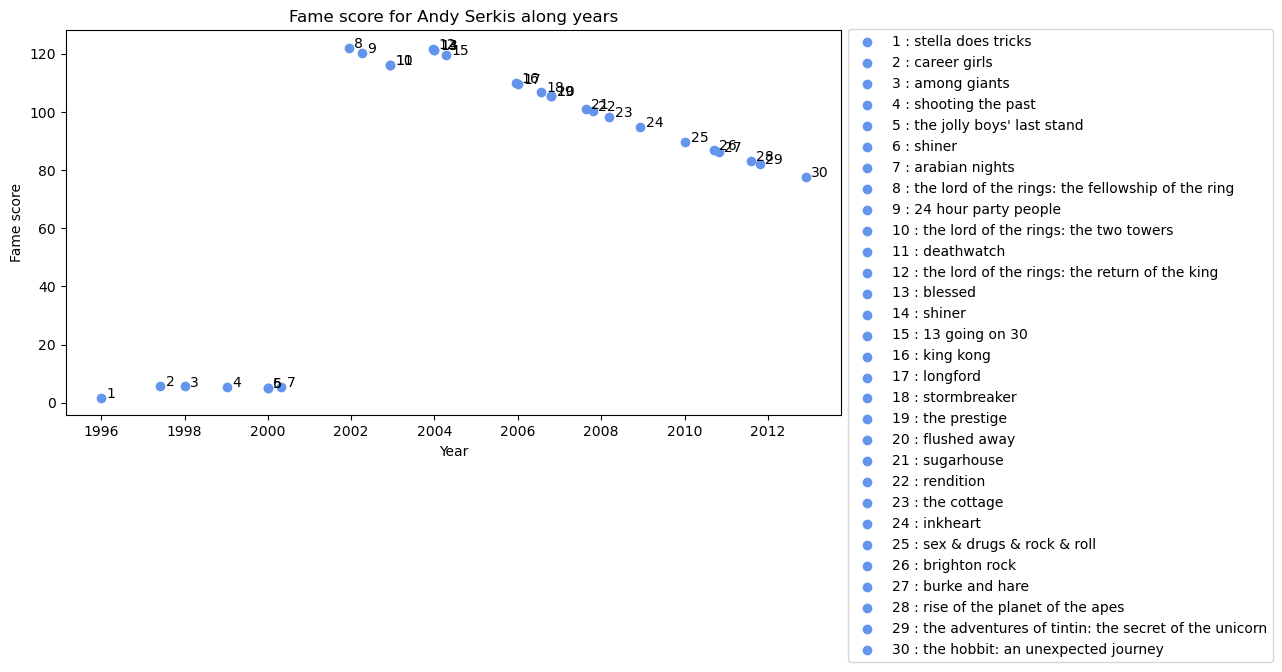

In [36]:
plot_filmography('Andy Serkis')

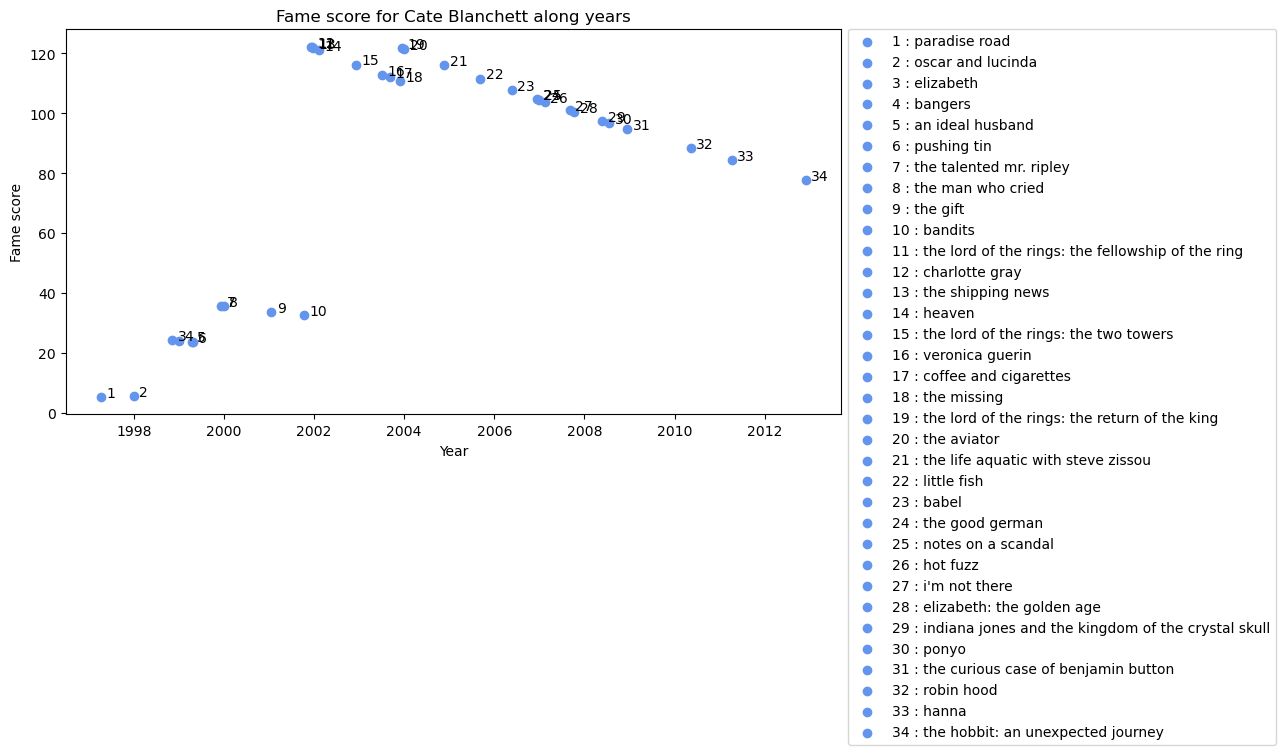

In [37]:
plot_filmography('Cate Blanchett')

We can see their that when Andy Serkis plays with Cate Blanchett, his fame score is higher than when he plays with other actors. This is a first indication that the fame of an actor may be impacted by the fame of the other actors he plays with.

Let's compute for each year the 100 most famous actresses and actors, that we think may be carreer or fame boosters for their colleagues.

In [38]:
def get_top100_actor(df):
    '''
    This function returns the top 100 actors with the highest fame score for each year
    '''

    # drop duplicates in case actor has several films in same year, keep the best fameScore attained that year
    df=df.sort_values(['freebase_actorID','fameScore']).drop_duplicates(subset='freebase_actorID', keep='last') 
    return df.iloc[np.argsort(df.fameScore.values)[-100:],:]

top100_actor_year=cmu_character.groupby(cmu_character.release_date.dt.year)[['wikiID','actor_name',
                                                                             'freebase_actorID','fameScore']] \
                               .apply(get_top100_actor) \
                               .reset_index(level=0)
top100_actor_year.sample(5)

,release_date,wikiID,actor_name,freebase_actorID,fameScore
21986,1997,3787708,Joe Pesci,/m/01pj5q,92.435218
320735,1922,5566075,Carl Stockdale,/m/0krwmw,17.827091
94867,1959,1343342,André Morell,/m/03k9k1,68.603556
330519,1931,1606658,Clara Bow,/m/0qksf,28.230306
324524,1949,14001162,Fred MacMurray,/m/0ly5n,72.660496


As we are interested in fame increases or decreases, we compute the fame's difference before and after portraying in a film. The fame score is computed using at most 3 past films, we then filter out the first 3 values to keep meaningful variations.

In [39]:
actor_fame_diff=cmu_character[['wikiID','freebase_actorID','fameScore_before','fameScore_after','release_date']].copy()
actor_fame_diff['fameScore_diff']=actor_fame_diff['fameScore_after']-actor_fame_diff['fameScore_before']
actor_fame_diff.drop(columns=['fameScore_after','fameScore_before'], inplace=True)
actor_fame_diff.sample(5)

,wikiID,freebase_actorID,release_date,fameScore_diff
157583,7269566,/m/06j035,1999-01-01,-0.004340
51412,887388,/m/02g5h5,1981-06-26,13.668270
105978,3170133,/m/0413mk1,1999-04-30,2.610101
18720,2544108,/m/01lc5,1923-02-26,-0.017491
246663,29836661,/m/0fb7c,1973-01-01,0.000000


We now want to create a table of featurings, where we will have for each actor an entry corresponding to an actor he/she played with in order to know the different connection between actors we have over the years.

In [40]:
# Create dataframe actor_feats linking an actor 1 benefitting from casting with an actor 2 
# (reverse relation is also present in dataframe)
actor_feats = cmu_character[['wikiID','actor_gender','actor_height','actor_ethnicity',
                             'actor_age_at_release','freebase_actorID','fameScore','persona','release_date']]
actor_feats = actor_feats.merge(actor_feats, on=['wikiID','release_date'])
actor_feats.columns = ['wikiID',
                       'actor_gender_1','actor_height_1','actor_ethnicity_1',
                       'actor_age_at_release_1','freebase_actorID_1','fameScore_1','persona_1',
                       'release_date',
                       'actor_gender_2','actor_height_2','actor_ethnicity_2',
                       'actor_age_at_release_2','freebase_actorID_2','fameScore_2','persona_2']

# Remove feats with itself
actor_feats = actor_feats[actor_feats.freebase_actorID_1!=actor_feats.freebase_actorID_2]
actor_feats.sample(5)

,wikiID,actor_gender_1,actor_height_1,actor_ethnicity_1,actor_age_at_release_1,freebase_actorID_1,fameScore_1,persona_1,release_date,actor_gender_2,actor_height_2,actor_ethnicity_2,actor_age_at_release_2,freebase_actorID_2,fameScore_2,persona_2
1028602,5649829,M,NaN,NaN,NaN,/m/0byrlyz,5.541989,NaN,2005-09-10,F,NaN,NaN,NaN,/m/05my64f,76.158851,NaN
446776,3517536,F,1.68,NaN,18.0,/m/068g1w,25.497783,NaN,2009-11-24,NaN,NaN,NaN,NaN,/m/09slbm8,25.497783,NaN
187278,31567568,M,NaN,NaN,NaN,/m/0ck7k11,3.766961,NaN,2009-09-01,M,NaN,NaN,NaN,/m/0j5fxq8,3.766961,NaN
1308126,2017211,M,1.85,NaN,56.0,/m/02p7_z,48.544092,NaN,2008-11-17,M,1.74,NaN,65.0,/m/01c65z,29.854604,NaN
353844,2154438,M,1.63,"Asian, Middle East and Tribes",21.0,/m/0gz5hs,21.085876,NaN,1995-10-05,M,NaN,NaN,37.0,/m/054_mz,129.793573,NaN


We need now to retrieve the fame score variation for the actor1 corresponding to the collaboration he/she made with the actor2.

In [41]:
# Merge on actor 1 in the feats with actor_fame_diff to get its fame variations
actor_feats = actor_feats.merge(actor_fame_diff, left_on=['wikiID','freebase_actorID_1','release_date'], 
                                right_on=['wikiID','freebase_actorID','release_date']) \
                         .drop(columns='freebase_actorID', axis=1)
actor_feats.sample(5)

,wikiID,actor_gender_1,actor_height_1,actor_ethnicity_1,actor_age_at_release_1,freebase_actorID_1,fameScore_1,persona_1,release_date,actor_gender_2,actor_height_2,actor_ethnicity_2,actor_age_at_release_2,freebase_actorID_2,fameScore_2,persona_2,fameScore_diff
1686965,12005853,F,1.65,NaN,29.0,/m/0391jz,48.098966,2.0,2008-09-26,M,NaN,NaN,NaN,/m/0bb8mbv,7.676510,NaN,-0.006589
1979825,11076424,M,1.78,"Black, Caribbean or African",39.0,/m/04tnqn,23.357708,46.0,2008-01-11,NaN,NaN,NaN,NaN,/m/03gfznr,4.556611,NaN,-0.003200
1732056,19720206,NaN,NaN,NaN,NaN,/m/0gd3bwm,0.659613,NaN,2011-01-01,M,1.867,NaN,71.0,/m/01pcbg,30.178019,NaN,0.659613
2668443,1569634,F,NaN,"Black, Caribbean or African",22.0,/m/0fd4nb,15.672592,NaN,2001-01-09,F,1.730,NaN,19.0,/m/02jtjz,41.169547,2.0,15.672592
877052,10839407,M,1.85,NaN,61.0,/m/031y07,40.880446,NaN,1974-11-22,M,1.842,NaN,66.0,/m/01v90t,16.572715,NaN,-0.005600


We now want to have the information on is the feat a feat with a "famous" actor (corresponding to our criteria it is the top100 famous actor of each year). 

In [42]:
# Apply a left join on actor_feats with the top100 actors on actor 2 of actor_feats as it is the one 
# from which actor 1 benefits. Left join allows to put NaNs when no match indicating that this feat 
# between actors does not contain a famous ones
actor_feats = actor_feats.merge(top100_actor_year[['wikiID','freebase_actorID']], \
                                left_on=['wikiID','freebase_actorID_2'], \
                                right_on=['wikiID','freebase_actorID'], how='left') \
                         .rename(columns={'freebase_actorID':'with_top100'})
actor_feats['with_top100'] = ~actor_feats['with_top100'].isna()

actor_feats.sample(5)

,wikiID,actor_gender_1,actor_height_1,actor_ethnicity_1,actor_age_at_release_1,freebase_actorID_1,fameScore_1,persona_1,release_date,actor_gender_2,actor_height_2,actor_ethnicity_2,actor_age_at_release_2,freebase_actorID_2,fameScore_2,persona_2,fameScore_diff,with_top100
468851,28397585,M,1.86,NaN,48.0,/m/0f1wry,17.118264,NaN,2011-09-01,M,1.93,White,47.0,/m/08996y,58.453960,NaN,11.531501,False
254031,2330988,M,1.89,White,38.0,/m/03h_9lg,114.226162,6.0,2006-10-22,M,NaN,White,42.0,/m/01pwjxk,22.963657,34.0,-0.015648,False
3513818,3077365,M,NaN,NaN,NaN,/m/0j7csvc,1.589409,NaN,1990-01-01,M,NaN,NaN,44.0,/m/0j7cr9z,1.907291,33.0,1.589409,False
132690,6724491,F,1.70,White,33.0,/m/0234_q,87.561062,49.0,1954-11-18,F,1.60,White,22.0,/m/0bmh4,19.958530,3.0,-0.011995,False
2779875,18363356,M,NaN,"Asian, Middle East and Tribes",NaN,/m/0gc6fr4,7.519253,NaN,1971-08-12,F,1.60,"Asian, Middle East and Tribes",20.0,/m/0cd7g0,1.154435,NaN,-0.001030,False


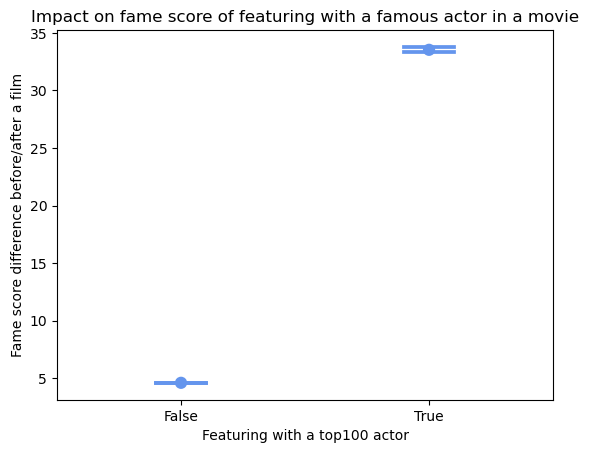

In [43]:
sns.pointplot(data=actor_feats, x='with_top100', y='fameScore_diff', color='cornflowerblue', 
              linestyles='none', capsize=0.2)#err_kws={'linewidth': 1}
plt.title('Impact on fame score of featuring with a famous actor in a movie')
plt.ylabel('Fame score difference before/after a film')
plt.xlabel('Featuring with a top100 actor');

In [44]:
stats.ttest_ind(actor_feats.query('with_top100==True')['fameScore_diff'].values, 
                actor_feats.query('with_top100==False')['fameScore_diff'].values)

TtestResult(statistic=807.4580736503448, pvalue=0.0, df=3526320.0)

The group of actors featuring with famous actors has a higher fame increase mean than the other one. 

The confidence intervals are not overlapping meaning that the null hypothesis stating that "Portraying in a film with a celebrity does not improve your fame score" can be rejected. This is confirmed through a t-test between their means yielding a p-value of 0.

These results motivate further analysis of what relations between actors influence the fame score evolution. Moreover, matching probably should be used as to compare group that are comparable, mitigating effects of confounders. Indeed, it could be that mostly already rising actors play with famous ones, to not hire only celebrities weighting more on the budget...

In [45]:
# keep only feats with no missing data on covariates of interest for matching
matching_data = actor_feats.dropna(subset=['actor_height_1','actor_height_2','actor_age_at_release_1','fameScore_1','actor_age_at_release_2',\
                                  'actor_gender_1','actor_gender_2','actor_ethnicity_1','actor_ethnicity_2','persona_1','persona_2']).copy()

# keep only actors with more than 3 films, useful to remove high fame increase from first film
def get_more_than_k_films(df):
    return df.iloc[2:,:]
matching_data=matching_data.groupby('freebase_actorID_1').apply(get_more_than_k_films).reset_index(level=0, drop=True)

matching_data['with_top100']=matching_data['with_top100'].astype(int)

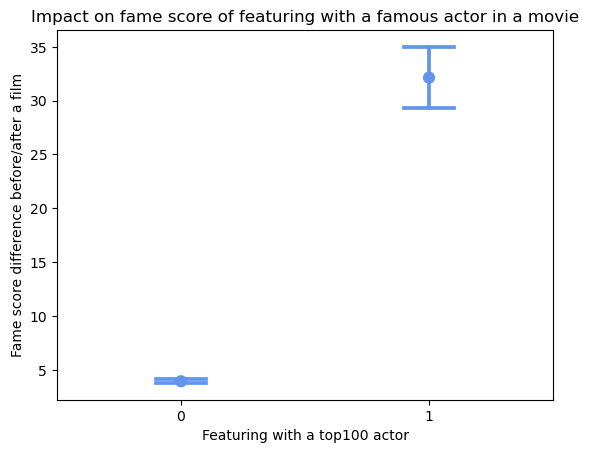

In [46]:
sns.pointplot(data=matching_data, x='with_top100', y='fameScore_diff', color='cornflowerblue', 
              linestyles='none', capsize=0.2)#err_kws={'linewidth': 1}
plt.title('Impact on fame score of featuring with a famous actor in a movie')
plt.ylabel('Fame score difference before/after a film')
plt.xlabel('Featuring with a top100 actor');

Between the two pointplots, means for actors featuring with known actors and those that do not are the same in the entire population and in the sample used for matching. The sample is hence representative of its population. Let's know perform excat matching on the actors ethnicities, gender and persona played for each actor in a relation. Moreover the ages should be balanced in both control and trated group so as to balance the effect of this condounder. Then, and probably most importantly, we match on the fameScore for the benefitting actor as if the actor is completely unknow are already famous we should expect different outcomes on average. Covariate fameScore for the fame providing actor is not balanced on as the treatment consist of featuring with a famous actor thus having  high fameScore. It is hence impossible to match this covariate.

In [47]:
matching_data['persona_1'] = matching_data['persona_1'].astype(int)
matching_data['persona_2'] = matching_data['persona_2'].astype(int)

matching_data = pd.get_dummies(matching_data, columns=['actor_gender_1','actor_gender_2','actor_ethnicity_1','actor_ethnicity_2'])
matching_data.columns = [col.replace(' ','_').replace(',','') for col in matching_data.columns]

In [48]:
formula = 'with_top100 ~ actor_height_1 + actor_age_at_release_1 + fameScore_1 + actor_height_2 + actor_age_at_release_2'

for col in matching_data.columns:
    if 'gender' in col or 'ethnicity' in col:
        formula += ' + C('+col+')'

mod = smf.logit(formula=formula, data=matching_data)
res = mod.fit()
print(res.summary())

matching_data['propensity']=res.predict()

Optimization terminated successfully.
         Current function value: 0.178450
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:            with_top100   No. Observations:                15971
Model:                          Logit   Df Residuals:                    15957
Method:                           MLE   Df Model:                           13
Date:                Mon, 18 Dec 2023   Pseudo R-squ.:                  0.1983
Time:                        03:48:30   Log-Likelihood:                -2850.0
converged:                       True   LL-Null:                       -3555.0
Covariance Type:            nonrobust   LLR p-value:                1.070e-293
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Interce

In [49]:
import networkx as nx
from tqdm import tqdm

def similarity(p1,p2):
        return 1-np.abs(p1-p2)

control=matching_data.query('with_top100==0')
treated=matching_data.query('with_top100==1')

G=nx.Graph()
for treated_id, treated_data in tqdm(treated.iterrows()):
        # exact matching on persona played
        c = control[np.all(control[['persona_1','persona_2']]==\
                           treated_data[['persona_1','persona_2']], axis=1)]
        
        # force fameScore_1 between control and treated to vary by 10% maximum otherwise too many already famous in treated group
        c = c[(np.abs((c['fameScore_1']-treated_data['fameScore_1'])/treated_data['fameScore_1']))<=0.1]
        
        similarity_ = list(map(lambda p1: similarity(p1,treated_data['propensity']), c['propensity']))
        
        edges = list(map(lambda x,y : [x, treated_id, y], c.index, similarity_))

        G.add_weighted_edges_from(edges)
        
print(G)
matching = nx.max_weight_matching(G)
print('Number of matches :',len(matching))

933it [00:03, 287.30it/s]


Graph with 4834 nodes and 10174 edges
Number of matches : 602


In [50]:
# retrieve matched feats
matched_actor_feats=matching_data.loc[[n[0] for n in matching] + [n[1] for n in matching]]
matched_actor_feats

,wikiID,actor_height_1,actor_age_at_release_1,freebase_actorID_1,fameScore_1,persona_1,release_date,actor_height_2,actor_age_at_release_2,freebase_actorID_2,...,actor_gender_2_M,actor_ethnicity_1_Asian_Middle_East_and_Tribes,actor_ethnicity_1_Black_Caribbean_or_African,actor_ethnicity_1_Mixed_or_multiple_ethnic_groups,actor_ethnicity_1_White,actor_ethnicity_2_Asian_Middle_East_and_Tribes,actor_ethnicity_2_Black_Caribbean_or_African,actor_ethnicity_2_Mixed_or_multiple_ethnic_groups,actor_ethnicity_2_White,propensity
2278736,7404698,1.770,70.0,/m/09fb5,106.889775,2,2007-12-16,1.880,70.0,/m/055c8,...,True,False,False,True,False,False,True,False,False,0.199924
888241,25001260,1.850,80.0,/m/0f13b,61.113561,29,2011-06-23,1.730,69.0,/m/03dn9v,...,True,True,False,False,False,False,False,False,True,0.037761
484786,872485,1.943,23.0,/m/01w23w,23.983086,2,1974-04-11,1.650,26.0,/m/01520h,...,True,False,False,False,True,True,False,False,False,0.017915
1145832,129644,1.780,34.0,/m/01yhd1,54.548039,41,1990-12-20,1.638,19.0,/m/01_f_5,...,False,False,False,False,True,False,False,True,False,0.047385
263510,31306385,1.708,34.0,/m/08258z,44.748402,49,2012-06-15,1.700,49.0,/m/07r1h,...,True,False,False,True,False,False,False,False,True,0.044991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1969947,5526366,1.651,38.0,/m/04wn6l,69.360225,45,1987-06-12,1.710,29.0,/m/0gx_p,...,False,False,False,False,True,False,False,True,False,0.083745
756666,236122,1.780,56.0,/m/0kjgl,50.498737,41,2001-09-24,1.920,41.0,/m/02xv8m,...,True,False,False,False,True,False,False,False,True,0.046645
2009272,22967108,1.750,47.0,/m/04t2l2,50.989861,6,2010-04-06,1.700,38.0,/m/0gy6z9,...,True,False,False,False,True,False,False,True,False,0.087185
642913,14941280,1.905,68.0,/m/0432cd,67.696574,22,2007-06-22,2.038,47.0,/m/01rcmg,...,True,False,False,False,True,True,False,False,False,0.066276


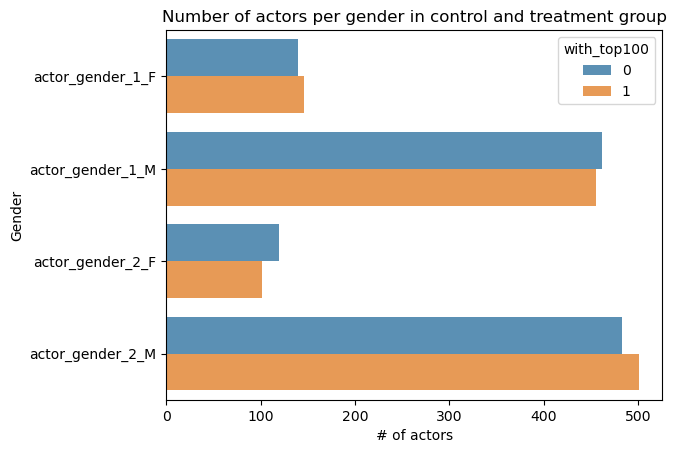

In [51]:
# Sanity check for gender exact matching
# matched_gender = pd.get_dummies(matched_actor_feats, columns=['actor_gender_1','actor_gender_2'])
# matched_gender = matched_gender[['with_top100']+[col for col in matched_gender.columns if 'gender' in col]].groupby('with_top100', as_index=False).sum()
matched_gender = matched_actor_feats[['with_top100']+[col for col in matched_actor_feats.columns if 'gender' in col]].groupby('with_top100', as_index=False).sum()
matched_gender = matched_gender.melt(id_vars='with_top100', value_name='count')

sns.barplot(x='count', y='variable', hue='with_top100', data=matched_gender, alpha=0.8)
plt.ylabel('Gender')
plt.xlabel('# of actors')
plt.title('Number of actors per gender in control and treatment group');

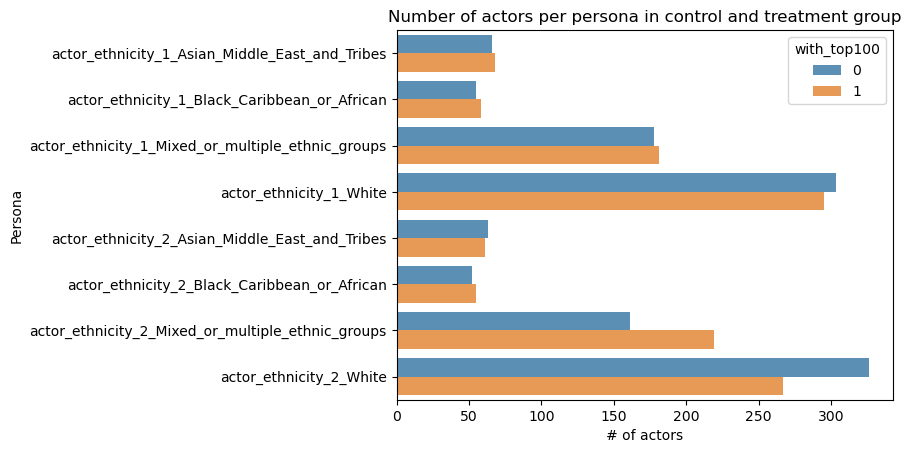

In [52]:
# Sanity check for ethnicity exact matching
# matched_ethnicity = pd.get_dummies(matched_actor_feats, columns=['actor_ethnicity_1','actor_ethnicity_2'])
# matched_ethnicity = matched_ethnicity[['with_top100']+[col for col in matched_ethnicity.columns if 'ethnicity' in col]].groupby('with_top100', as_index=False).sum()
matched_ethnicity = matched_actor_feats[['with_top100']+[col for col in matched_actor_feats.columns if 'ethnicity' in col]].groupby('with_top100', as_index=False).sum()
matched_ethnicity = matched_ethnicity.melt(id_vars='with_top100', value_name='count')

sns.barplot(x='count', y='variable', hue='with_top100', data=matched_ethnicity, alpha=0.8)
plt.ylabel('Persona')
plt.xlabel('# of actors')
plt.title('Number of actors per persona in control and treatment group');

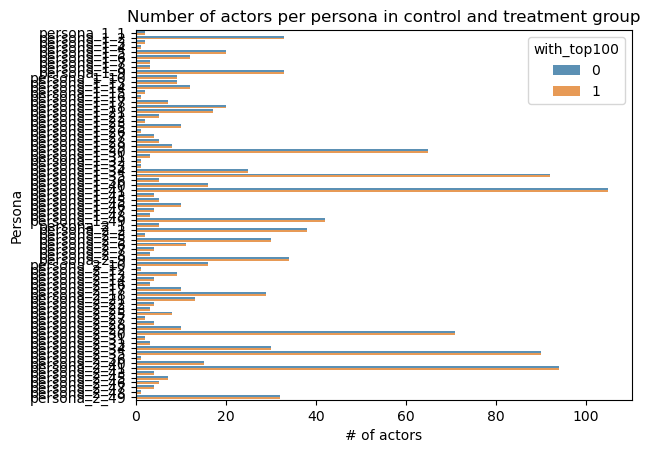

In [53]:
# Sanity check for persona exact matching
matched_persona = pd.get_dummies(matched_actor_feats, columns=['persona_1','persona_2'])
matched_persona = matched_persona[['with_top100']+[col for col in matched_persona.columns if 'persona' in col]].groupby('with_top100', as_index=False).sum()
matched_persona = matched_persona.melt(id_vars='with_top100', value_name='count')

sns.barplot(x='count', y='variable', hue='with_top100', data=matched_persona, alpha=0.8)
plt.ylabel('Persona')
plt.xlabel('# of actors')
plt.title('Number of actors per persona in control and treatment group');

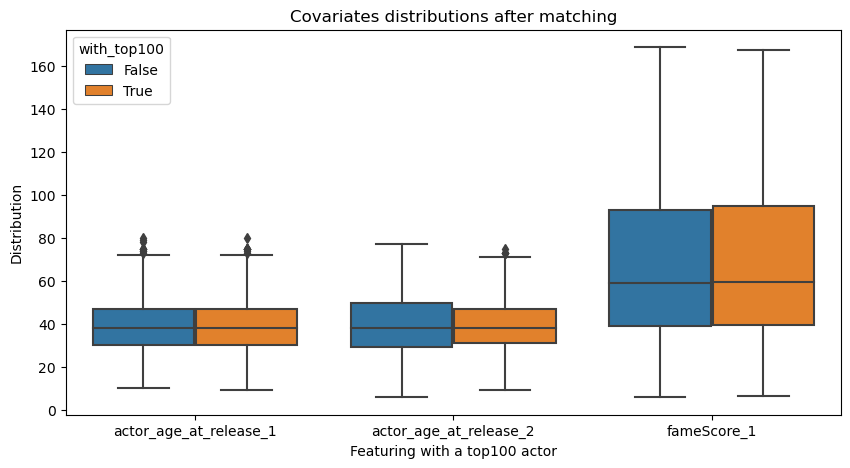

In [54]:
# Sanity check for age at film release for both actors and fameScrore for benefitting actor
matched_actor_feats['actor_age_at_release_1']=matched_actor_feats['actor_age_at_release_1'].astype(int)
matched_actor_feats['actor_age_at_release_2']=matched_actor_feats['actor_age_at_release_2'].astype(int)
matched_actor_feats['with_top100']=matched_actor_feats['with_top100'].astype(bool)

plt.figure(figsize=(10,5))
sns.boxplot(data=matched_actor_feats[['actor_age_at_release_1','actor_age_at_release_2','fameScore_1','with_top100']]\
                    .melt(value_vars=['actor_age_at_release_1','actor_age_at_release_2','fameScore_1'],
                          id_vars='with_top100'),
            y='value',
            x='variable',
            hue='with_top100')
plt.title('Covariates distributions after matching')
plt.ylabel('Distribution')
plt.xlabel('Featuring with a top100 actor');

Both groups have similar distributions over observed covariates, therefore we may now under the naive model consider that any observable effect is not due to an observable confounder.

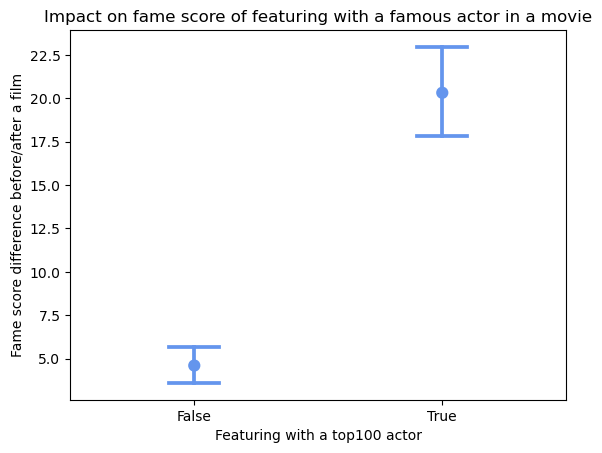

In [55]:
sns.pointplot(data=matched_actor_feats, x='with_top100', y='fameScore_diff', color='cornflowerblue', 
              linestyles='none', capsize=0.2)#err_kws={'linewidth': 1}
plt.title('Impact on fame score of featuring with a famous actor in a movie')
plt.ylabel('Fame score difference before/after a film')
plt.xlabel('Featuring with a top100 actor');

In [56]:
stats.ttest_ind(matched_actor_feats.query('with_top100==1')['fameScore_diff'].values, 
                matched_actor_feats.query('with_top100==0')['fameScore_diff'].values)

TtestResult(statistic=11.440665863325956, pvalue=7.656396860779842e-29, df=1202.0)

### Network analysis

In [57]:
# Helper function for plotting the degree distribution of a Graph
def plot_degree_distribution(G):
    degrees = {}
    for node in G.nodes():
        degree = G.degree(node)
        if degree not in degrees:
            degrees[degree] = 0
        degrees[degree] += 1
    sorted_degree = sorted(degrees.items())
    deg = [k for (k,v) in sorted_degree]
    cnt = [v for (k,v) in sorted_degree]
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')
    plt.title("Degree Distribution")
    plt.ylabel("Frequency")
    plt.xlabel("Degree")
    ax.set_xticks([d+0.05 for d in deg])
    ax.set_xticklabels(deg)

# Helper function for printing various graph properties
def describe_graph(G):
    print(G)
    if nx.is_connected(G):
        print("Avg. Shortest Path Length: %.4f" %nx.average_shortest_path_length(G))
        print("Diameter: %.4f" %nx.diameter(G)) # Longest shortest path
    else:
        print("Graph is not connected")
        print("Diameter and Avg shortest path length are not defined!")
    print("Sparsity: %.4f" %nx.density(G))  # #edges/#edges-complete-graph
    # #closed-triplets(3*#triangles)/#all-triplets
    print("Global clustering coefficient aka Transitivity: %.4f" %nx.transitivity(G))

# Helper function for visualizing the graph
def visualize_graph(G, with_labels=True, k=None, alpha=1.0, node_shape='o'):
    #nx.draw_spring(G, with_labels=with_labels, alpha = alpha)
    pos = nx.spring_layout(G, k=k)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]))
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color='g', node_shape=node_shape)
    plt.axis('off')

In [58]:
# create a graph of actors connected by films made together. The graph time dependence is here not considered.
G = nx.from_pandas_edgelist(matching_data, 'freebase_actorID_1', 'freebase_actorID_2')

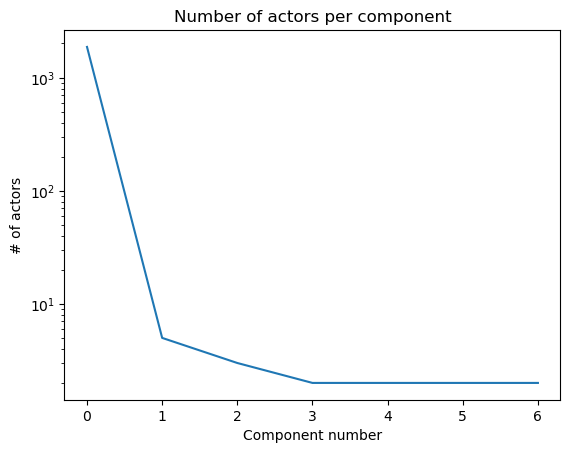

In [59]:
components = list(nx.connected_components(G)) # cut graph into N connected components
components = sorted(components, key=len) # sort then of size
components.reverse()
components_number = {n:np.argmax([n in c for c in components]) for n in G.nodes()} # assign number to each component
nx.set_node_attributes(G, components_number, 'comp')

plt.plot([len(c) for c in components])
plt.title('Number of actors per component')
plt.ylabel('# of actors')
plt.xlabel('Component number')
plt.yscale('log')

The actor network is not connected but the vast majority of actors belong to the same component. In future analysis, we will restrict ourselves to this main connected components.

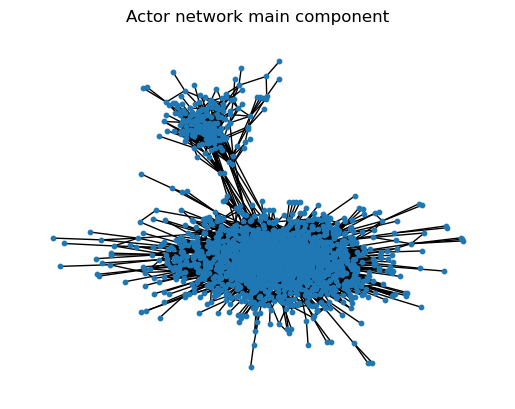

In [60]:
# get subgraph of G containing main component. Very few nodes are lost actuallly
G = nx.subgraph(G, components[0])

pos = nx.spring_layout(G, seed=0)
nx.draw_networkx_nodes(G, pos=pos, node_size=10)
nx.draw_networkx_edges(G, pos=pos);
plt.axis('off')
plt.title('Actor network main component');

The networks appears to be splitted in two main groups. Let's recall that our dataset provides films from all over the world in many different languages. It would hence make sense to observe some clusters of actors with many connections as they play in a certain country cinema industry. Our first guess is that the main cluster corresponds to Hollywood actors while the smaller one is Bollywood. It is to note that some weak ties link these two worlds, probably being actors who portrayed is films in both Hollywood and Bollywood, hence having connections in both. Let's confirm or not the validity of this hypothesis.

In [61]:
def get_main_language(df):
    '''
    This function returns the language with the most occurences
    in an actor filmography given as input.
    '''
    lst=np.hstack(df['language']).tolist()
    if lst==[]:
        return 'NoLanguage'
    return max(lst, key=lst.count)

# get the language with most occurences for each actor
actor_language = cmu_character.merge(cmu_movies[['wikiID','language']]).groupby('freebase_actorID').apply(get_main_language).to_dict()
# creates mapping from language to number (used for plots)
language_num_dict = {l:n for l,n in zip(actor_language.values(), range(len(actor_language)))}

# add the language attribute to actor nodes
nx.set_node_attributes(G, {n:actor_language[n] for n in G.nodes()}, 'language')

/home/remi/Anaconda3/envs/ada/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


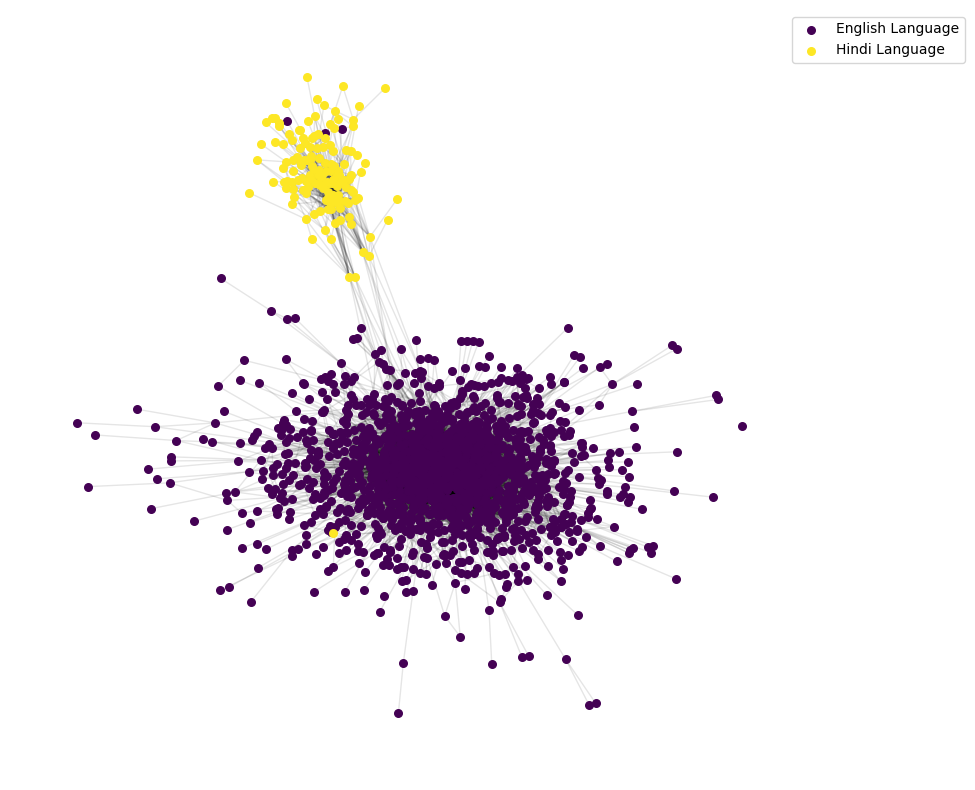

In [62]:
# keep only languages with more than 20 actors otherwise too many similar color with viridis color map
languages, counts = np.unique([G.nodes()[n]['language'] for n in G.nodes()], return_counts=True)
languages = languages[counts > 20]

# define color map and sample 6 colors
cmap = plt.colormaps["viridis"].resampled(len(languages))
colors = cmap.colors.tolist()


plt.figure(figsize=(10,10))
nx.draw_networkx_edges(G, pos=pos,alpha=0.1, edgelist=[e for e in G.edges() if G.nodes()[e[0]]['language'] in languages and G.nodes()[e[1]]['language'] in languages])

for i,language in enumerate(languages):
    # isolate subgraph of actors with 'language' as most occuring language
    subG = nx.subgraph(G, [n for n in G.nodes() if G.nodes()[n]['language']==language])
    # get their positions in orignal spring_layout
    subpos = {n:p for n,p in pos.items() if G.nodes()[n]['language']==language}
    nx.draw_networkx_nodes(subG,
                           pos=subpos,
                           node_size=30,
                           node_color=colors[i],
                           label=language,
                           alpha=1)

plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.axis('off');

Our initial hypothesis is verified as the main group of actors only features English speaking actors. On the other hand the smaller, clusters comprises actors speaking Hindi.

In future analysis, we would like to study the links between network centrality using the betweenness, katz and closeness centrality metrics. However, we face an issue because of the nature of the network. Indeed, actors with high betweenness centrality would be those linking Bollywood and Hollywood but there are no guarantees for their fame. Let's first confirm this by computing the betweenness centrality of all nodes.

In [63]:
# Compute betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
# Assign the computed centrality values as a node-attribute in your network
nx.set_node_attributes(G, betweenness_centrality, 'betweenness')

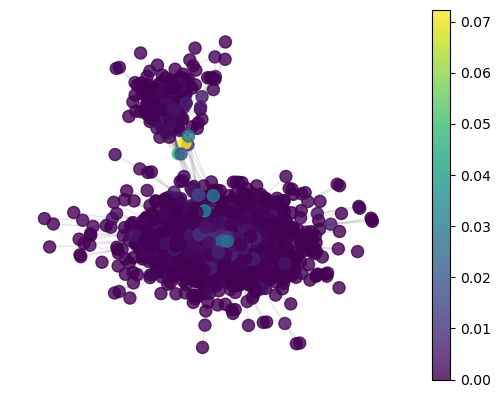

In [64]:
list_nodes =list(G.nodes())
list_nodes.reverse()   # for showing the nodes with high betweeness centrality 
ec = nx.draw_networkx_edges(G, pos, alpha=0.1)
nc = nx.draw_networkx_nodes(G, pos, nodelist=list_nodes, node_color=[G.nodes[n]["betweenness"] for n in list_nodes], 
                            alpha=0.8, node_shape = '.')
plt.colorbar(nc)
plt.axis('off')
plt.show()

Our concerns are confirmed as high centrality is characterized by actors linking Hollywood and Bollywood. We will hence restrict our analysis to English speaking actors in the subsequent cells, namely Hollywood.

In [65]:
# get subgraph of English speaking actors
G = nx.subgraph(G, [n for n in G.nodes() if 'English' in G.nodes()[n]['language']])

# get main connected component among Englih speaking actors
components = list(nx.connected_components(G)) 
components = sorted(components, key=len)
components.reverse()
G = nx.subgraph(G, components[0])

print(G)

Graph with 1619 nodes and 7874 edges


Let's now compute betweenness, katz and closeness centrality for Hollywood actors.

In [66]:
# Compute betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
# Assign the computed centrality values as a node-attribute in your network
nx.set_node_attributes(G, betweenness_centrality, 'betweenness_centrality')

In [67]:
betweenness = pd.DataFrame({'freebase_actorID':betweenness_centrality.keys(), 'betweenness_centrality':betweenness_centrality.values()})
# merge with cmu_character to get actor names
betweenness.merge(cmu_character[['freebase_actorID','actor_name']])\
           .drop_duplicates()\
           .sort_values('betweenness_centrality',ascending=False)\
           .head(10)

,freebase_actorID,betweenness_centrality,actor_name
6505,/m/06cgy,0.037797,Robert De Niro
943,/m/055c8,0.027542,Morgan Freeman
7588,/m/016fjj,0.025640,Christopher Walken
1553,/m/04yj5z,0.022327,John Leguizamo
10609,/m/0h5g_,0.020151,Liam Neeson
8269,/m/02lymt,0.019810,Wesley Snipes
10910,/m/0f5xn,0.018902,Samuel L. Jackson
8083,/m/014gf8,0.018414,Laurence Fishburne
250,/m/0171cm,0.018403,Tom Wilkinson
9052,/m/01w23w,0.017668,Randy Quaid


In [68]:
# use max(nx.adjacency_spectrum(G)) as algorithm converges for alpha < 1/max(adjacency_eigen_values)
katz_centrality = nx.katz_centrality(G, alpha=0.9/max(abs(nx.adjacency_spectrum(G))))
# Assign the computed centrality values as a node-attribute in your network
nx.set_node_attributes(G, katz_centrality, 'katz_centrality')

In [69]:
katz = pd.DataFrame({'freebase_actorID':katz_centrality.keys(), 'katz_centrality':katz_centrality.values()})
# merge with cmu_character to get actor names
katz.merge(cmu_character[['freebase_actorID','actor_name']])\
    .drop_duplicates()\
    .sort_values('katz_centrality',ascending=False)\
    .head(10)

,freebase_actorID,katz_centrality,actor_name
6505,/m/06cgy,0.129709,Robert De Niro
943,/m/055c8,0.128515,Morgan Freeman
1553,/m/04yj5z,0.107151,John Leguizamo
6705,/m/0169dl,0.103759,Matt Damon
7588,/m/016fjj,0.099831,Christopher Walken
10609,/m/0h5g_,0.099626,Liam Neeson
5889,/m/046zh,0.099110,Julia Roberts
12750,/m/0mdqp,0.093017,Ben Stiller
2218,/m/02qgyv,0.092000,John C. Reilly
18648,/m/0bksh,0.089822,Cameron Diaz


In [70]:
closeness_centrality = nx.closeness_centrality(G)
# Assign the computed centrality values as a node-attribute in your network
nx.set_node_attributes(G, closeness_centrality, 'closeness_centrality')

In [71]:
closeness = pd.DataFrame({'freebase_actorID':closeness_centrality.keys(), 'closeness_centrality':closeness_centrality.values()})
# merge with cmu_character to get actor names
closeness.merge(cmu_character[['freebase_actorID','actor_name']])\
         .drop_duplicates()\
         .sort_values('closeness_centrality',ascending=False)\
         .head(10)

,freebase_actorID,closeness_centrality,actor_name
6505,/m/06cgy,0.388755,Robert De Niro
943,/m/055c8,0.384049,Morgan Freeman
7588,/m/016fjj,0.377420,Christopher Walken
1553,/m/04yj5z,0.375493,John Leguizamo
5889,/m/046zh,0.369998,Julia Roberts
15925,/m/0205dx,0.369322,Danny Glover
5120,/m/07r1h,0.367477,Tom Cruise
12750,/m/0mdqp,0.366561,Ben Stiller
8083,/m/014gf8,0.366395,Laurence Fishburne
10609,/m/0h5g_,0.365815,Liam Neeson


In [72]:
from community import community_louvain

partition = community_louvain.best_partition(G, random_state=0)
# add it as an attribute to the nodes
for n in G.nodes:
    G.nodes[n]["louvain"] = partition[n]

In [73]:
number_communities = len(np.unique(list(partition.values())))
number_communities

20

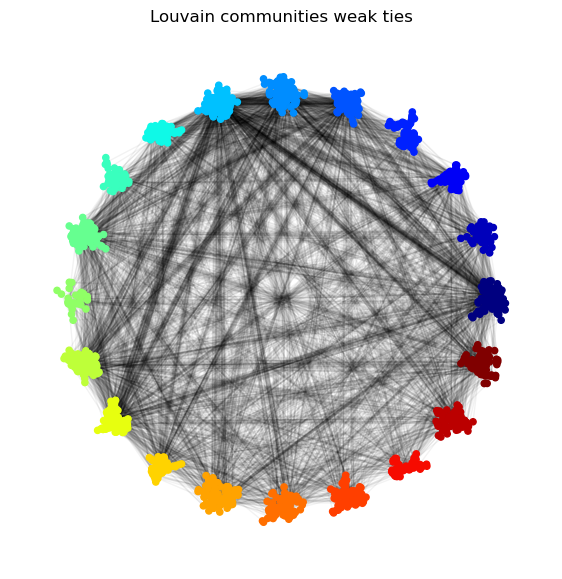

In [74]:
cmap = plt.colormaps["viridis"].resampled(number_communities)
colors = cmap.colors.tolist()

circle_G = nx.Graph()
circle_G.add_nodes_from(np.arange(number_communities))
circle_pos = {k:10*v for k,v in nx.circular_layout(circle_G).items()}

pos_coms = {}
for com in range(number_communities):
    G_com = nx.subgraph(G, [n for n in G.nodes() if G.nodes()[n]['louvain']==com])
    pos_coms.update({k:v+circle_pos[com] for k,v in nx.spring_layout(G_com).items()})

plt.figure(figsize=(7,7))
nx.draw_networkx_edges(G, pos=pos_coms, alpha=0.05)
nx.draw_networkx_nodes(G, pos=pos_coms, node_color=[G.nodes[n]["louvain"] for n in G.nodes()], node_size=20,cmap=plt.cm.jet)
plt.title('Louvain communities weak ties')
plt.axis('off');

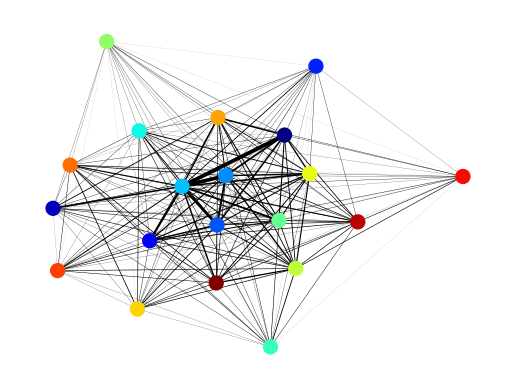

In [75]:
weak_ties = pd.DataFrame([[e[0], G.nodes()[e[0]]['louvain'], e[1], G.nodes()[e[1]]['louvain']] for e in G.edges() if G.nodes()[e[0]]['louvain']!=G.nodes()[e[1]]['louvain']],
                     columns=['node_1','louvain_1','node_2','louvain_2'])

edges_com = weak_ties.groupby(['louvain_1','louvain_2']).agg(weight=('node_1','count'))

G_com = nx.from_pandas_edgelist(edges_com.reset_index(),'louvain_1','louvain_2','weight')

pos_com = nx.spring_layout(G_com, seed=1)
nx.draw_networkx_edges(G_com, pos=pos_com, alpha=1, width=[G_com.edges()[e]['weight']/25 for e in G_com.edges()])
nx.draw_networkx_nodes(G_com, pos=pos_com, node_color=range(number_communities), node_size=100,cmap=plt.cm.jet)
plt.axis('off');

je prefere le graph circulaire et vous ?

In [76]:
actor_louvain = cmu_character[['freebase_actorID','fameScore','fameScore_before']]\
                .merge(pd.DataFrame({'freebase_actorID':partition.keys(),
                                     'louvain':partition.values()}))

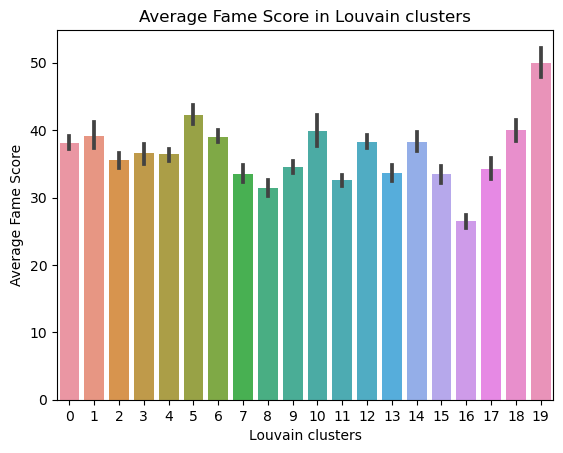

In [77]:
sns.barplot(data=actor_louvain, x='louvain',y='fameScore')
plt.xlabel('Louvain clusters')
plt.ylabel('Average Fame Score')
plt.title('Average Fame Score in Louvain clusters');

In [78]:
samples=[]
for i in range(number_communities):
    samples += [actor_louvain.query(f'louvain=={i}').fameScore.values]

stats.f_oneway(*samples)

F_onewayResult(statistic=47.179887328707316, pvalue=1.347112863013532e-175)

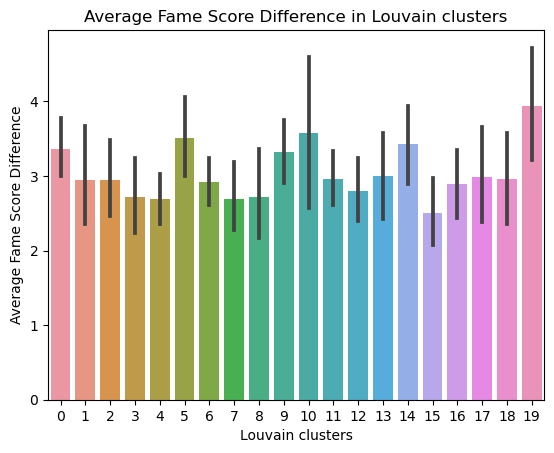

In [79]:
actor_louvain['fameScore_diff']=actor_louvain['fameScore']-actor_louvain['fameScore_before']

sns.barplot(data=actor_louvain, x='louvain',y='fameScore_diff')
plt.xlabel('Louvain clusters')
plt.ylabel('Average Fame Score Difference')
plt.title('Average Fame Score Difference in Louvain clusters');

In [80]:
samples=[]
for i in range(number_communities):
    samples += [actor_louvain.query(f'louvain=={i}').fameScore_diff.values]

stats.f_oneway(*samples)

F_onewayResult(statistic=1.833862299984645, pvalue=0.014620886742074072)

according to anova, louvain groups do not have the same population mean for famescore and fameScore_diff so actor should aim at joining certain communities

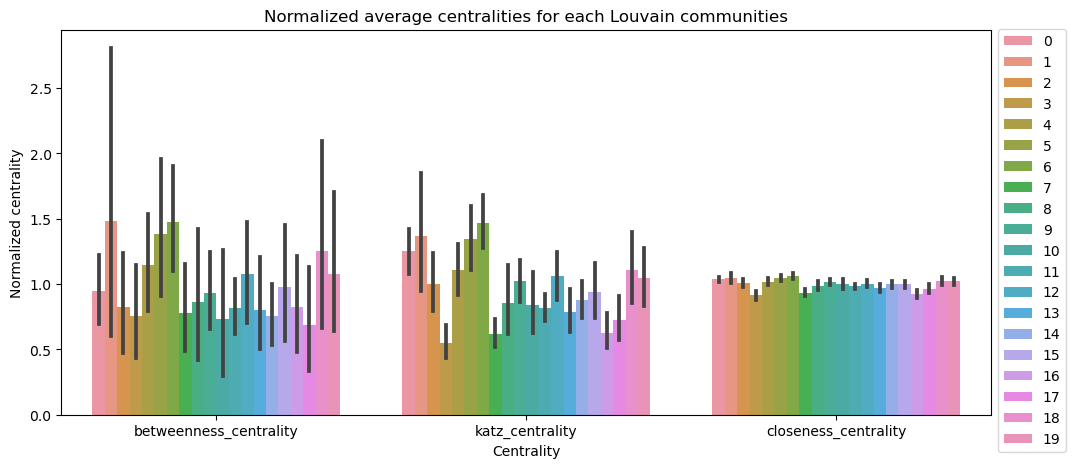

In [81]:
# is there a community more central than others

centralities = pd.DataFrame({'freebase_actorID':partition.keys(),'louvain':partition.values()})\
                            .merge(betweenness, on='freebase_actorID')\
                            .merge(katz, on='freebase_actorID')\
                            .merge(closeness, on='freebase_actorID')

centralities[['betweenness_centrality','katz_centrality','closeness_centrality']] /=\
      np.mean(centralities[['betweenness_centrality','katz_centrality','closeness_centrality']], axis=0)

plt.figure(figsize=(12,5))
sns.barplot(centralities.melt(id_vars='louvain',
                              value_vars=['betweenness_centrality','katz_centrality','closeness_centrality'],
                              value_name='Normalized centrality',
                              var_name='Centrality'),
            y='Normalized centrality',
            hue='louvain',
            x='Centrality')

plt.title('Normalized average centralities for each Louvain communities')
plt.legend(loc='upper left', bbox_to_anchor=(1,1.02));

In [82]:
for centrality in centralities.columns[-3:]:
    samples=[]
    for i in range(number_communities):
        samples += [centralities.query(f"louvain=={i}")[centrality].values]

    f,pvalue = stats.f_oneway(*samples)
    print(f'{centrality} : (f : {f}, p-value : {pvalue})')

betweenness_centrality : (f : 1.3813046927016415, p-value : 0.12552739333532917)
katz_centrality : (f : 6.895219338412367, p-value : 6.4443248534419464e-18)
closeness_centrality : (f : 8.853513815882799, p-value : 1.7837364667656786e-24)


Some communities clearly are more central than others, actors should aim at joining the most central ones if central equivalent to famous

In [83]:
matching_data = matching_data.merge(centralities, left_on='freebase_actorID_1', right_on='freebase_actorID').drop(columns='freebase_actorID')
matching_data.columns = list(matching_data.columns[:-4])+[col+'_1' for col in matching_data.columns[-4:]]
matching_data = matching_data.merge(centralities, left_on='freebase_actorID_2', right_on='freebase_actorID').drop(columns='freebase_actorID')
matching_data.columns = list(matching_data.columns[:-4])+[col+'_2' for col in matching_data.columns[-4:]]
matching_data.head()

,wikiID,actor_height_1,actor_age_at_release_1,freebase_actorID_1,fameScore_1,persona_1,release_date,actor_height_2,actor_age_at_release_2,freebase_actorID_2,...,actor_ethnicity_2_White,propensity,louvain_1,betweenness_centrality_1,katz_centrality_1,closeness_centrality_1,louvain_2,betweenness_centrality_2,katz_centrality_2,closeness_centrality_2
0,3493076,1.85,37.0,/m/010xjr,20.704053,27,1967-10-25,1.8,30.0,/m/0h32q,...,True,0.007912,0,1.967374,1.806001,1.121461,0,2.171474,1.767405,1.145923
1,133622,1.71,32.0,/m/0159h6,15.080825,49,1992-03-13,1.8,55.0,/m/0h32q,...,True,0.006841,0,3.179895,2.873765,1.175806,0,2.171474,1.767405,1.145923
2,1566225,1.73,25.0,/m/01g25r,62.684687,49,2000-03-05,1.8,63.0,/m/0h32q,...,True,0.031628,11,0.891616,1.099628,1.085531,0,2.171474,1.767405,1.145923
3,459586,1.80,32.0,/m/01wskg,23.526630,5,1971-01-01,1.8,33.0,/m/0h32q,...,True,0.008956,13,0.259661,0.346165,0.893180,0,2.171474,1.767405,1.145923
4,25698427,1.68,31.0,/m/037kr_,39.103403,49,2010-04-25,1.8,73.0,/m/0h32q,...,True,0.012325,0,0.016717,0.436180,0.948514,0,2.171474,1.767405,1.145923


In [84]:
matching_data['treatment'] = (matching_data['louvain_1']==matching_data['louvain_2']).astype(int)

formula = 'treatment ~ actor_height_1 + actor_age_at_release_1 + fameScore_1 + actor_height_2 + actor_age_at_release_2 + fameScore_2'
# formula += ' + betweenness_centrality_1 + katz_centrality_1 + closeness_centrality_1'
# formula += ' + betweenness_centrality_2 + katz_centrality_2 + closeness_centrality_2'

for col in matching_data.columns:
    if 'gender' in col or 'ethnicity' in col:
        formula += ' + C('+col+')'

mod = smf.logit(formula=formula, data=matching_data)
res = mod.fit()
print(res.summary())

matching_data['propensity']=res.predict()

         Current function value: 0.682215
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                14260
Model:                          Logit   Df Residuals:                    14245
Method:                           MLE   Df Model:                           14
Date:                Mon, 18 Dec 2023   Pseudo R-squ.:                0.009567
Time:                        03:51:08   Log-Likelihood:                -9728.4
converged:                      False   LL-Null:                       -9822.4
Covariance Type:            nonrobust   LLR p-value:                 1.575e-32
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                   

/home/remi/Anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [85]:
import networkx as nx
from tqdm import tqdm

def similarity(p1,p2):
        return 1-np.abs(p1-p2)

control=matching_data.query('treatment==0')
treated=matching_data.query('treatment==1')

G=nx.Graph()

centrality_tol=0.3
for treated_id, treated_data in tqdm(treated.iterrows()):
        # exact matching on persona played
        c = control[np.all(control[['persona_1','persona_2','with_top100']]==\
                           treated_data[['persona_1','persona_2','with_top100']], axis=1)]

        # force centrality to vary by a tolerance maximum, mostly useful to reduce number of nodes in max_weight_matching
        c = c[(np.abs((c['betweenness_centrality_1']-treated_data['betweenness_centrality_1'])/treated_data['betweenness_centrality_1']))<=centrality_tol]
        c = c[(np.abs((c['betweenness_centrality_2']-treated_data['betweenness_centrality_1'])/treated_data['betweenness_centrality_1']))<=centrality_tol]
        c = c[(np.abs((c['katz_centrality_1']-treated_data['katz_centrality_1'])/treated_data['katz_centrality_1']))<=centrality_tol]
        c = c[(np.abs((c['katz_centrality_2']-treated_data['katz_centrality_2'])/treated_data['katz_centrality_2']))<=centrality_tol]
        c = c[(np.abs((c['closeness_centrality_1']-treated_data['closeness_centrality_1'])/treated_data['closeness_centrality_1']))<=centrality_tol]
        c = c[(np.abs((c['closeness_centrality_2']-treated_data['closeness_centrality_2'])/treated_data['closeness_centrality_2']))<=centrality_tol]
        
        similarity_ = list(map(lambda p1: similarity(p1,treated_data['propensity']), c['propensity']))
        
        edges = list(map(lambda x,y : [x, treated_id, y], c.index, similarity_))

        G.add_weighted_edges_from(edges)
        
print(G)
matching = nx.max_weight_matching(G)
print('Number of matches :',len(matching))

6466it [00:43, 148.11it/s]


Graph with 1061 nodes and 1247 edges
Number of matches : 377


In [86]:
# retrieve matched feats
matched_actor_feats=matching_data.loc[[n[0] for n in matching] + [n[1] for n in matching]]
matched_actor_feats.sample(5)

,wikiID,actor_height_1,actor_age_at_release_1,freebase_actorID_1,fameScore_1,persona_1,release_date,actor_height_2,actor_age_at_release_2,freebase_actorID_2,...,propensity,louvain_1,betweenness_centrality_1,katz_centrality_1,closeness_centrality_1,louvain_2,betweenness_centrality_2,katz_centrality_2,closeness_centrality_2,treatment
6126,385706,1.730,41.0,/m/01vlj1g,70.759708,34,2004-02-10,1.6500,48.0,/m/01nxzv,...,0.454613,2,3.118108,2.427535,1.184318,2,2.560094,2.206283,1.170279,1
490,1962913,1.750,28.0,/m/01pllx,52.582353,35,1993-11-12,1.7500,26.0,/m/01rzqj,...,0.450932,4,4.550211,2.478788,1.196693,4,5.325009,3.537344,1.242930,1
3342,355548,1.730,28.0,/m/018db8,107.823838,34,2003-10-20,1.5494,50.0,/m/02n4b9,...,0.512389,4,2.321879,2.695618,1.201464,4,0.686968,1.225995,1.094871,1
5503,441315,1.740,24.0,/m/01mqc_,49.780953,41,1993-09-10,1.7800,35.0,/m/01f6zc,...,0.436709,18,4.172205,3.110077,1.231701,18,4.748286,3.513924,1.240238,1
6009,6846215,1.905,37.0,/m/01chc7,74.427161,34,2008-12-11,1.6300,63.0,/m/01hkhq,...,0.415189,14,2.324658,2.089775,1.155636,0,2.677315,3.162061,1.228003,0


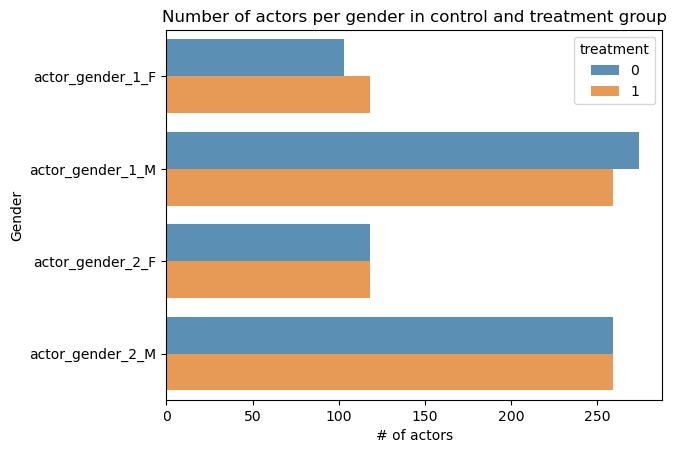

In [87]:
# Sanity check for gender exact matching
# matched_gender = pd.get_dummies(matched_actor_feats, columns=['actor_gender_1','actor_gender_2'])
# matched_gender = matched_gender[['treatment']+[col for col in matched_gender.columns if 'gender' in col]].groupby('treatment', as_index=False).sum()
matched_gender = matched_actor_feats[['treatment']+[col for col in matched_actor_feats.columns if 'gender' in col]].groupby('treatment', as_index=False).sum()
matched_gender = matched_gender.melt(id_vars='treatment', value_name='count')

sns.barplot(x='count', y='variable', hue='treatment', data=matched_gender, alpha=0.8)
plt.ylabel('Gender')
plt.xlabel('# of actors')
plt.title('Number of actors per gender in control and treatment group');

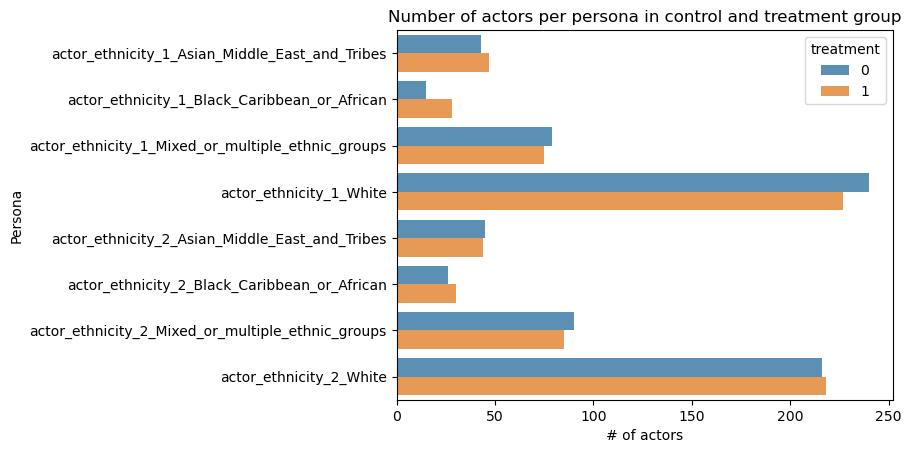

In [88]:
# Sanity check for ethnicity exact matching
# matched_ethnicity = pd.get_dummies(matched_actor_feats, columns=['actor_ethnicity_1','actor_ethnicity_2'])
# matched_ethnicity = matched_ethnicity[['treatment']+[col for col in matched_ethnicity.columns if 'ethnicity' in col]].groupby('treatment', as_index=False).sum()
matched_ethnicity = matched_actor_feats[['treatment']+[col for col in matched_actor_feats.columns if 'ethnicity' in col]].groupby('treatment', as_index=False).sum()
matched_ethnicity = matched_ethnicity.melt(id_vars='treatment', value_name='count')

sns.barplot(x='count', y='variable', hue='treatment', data=matched_ethnicity, alpha=0.8)
plt.ylabel('Persona')
plt.xlabel('# of actors')
plt.title('Number of actors per persona in control and treatment group');

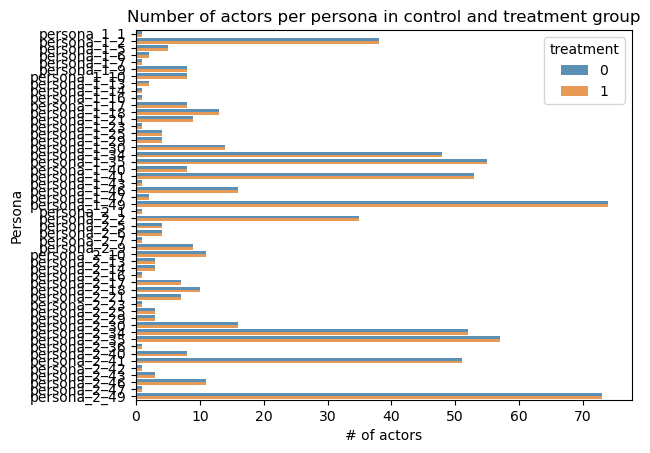

In [89]:
# Sanity check for persona exact matching
matched_persona = pd.get_dummies(matched_actor_feats, columns=['persona_1','persona_2'])
matched_persona = matched_persona[['treatment']+[col for col in matched_persona.columns if 'persona' in col]].groupby('treatment', as_index=False).sum()
matched_persona = matched_persona.melt(id_vars='treatment', value_name='count')

sns.barplot(x='count', y='variable', hue='treatment', data=matched_persona, alpha=0.8)
plt.ylabel('Persona')
plt.xlabel('# of actors')
plt.title('Number of actors per persona in control and treatment group');

In [90]:
matched_actor_feats.groupby('treatment').agg(with_top00_avg=('with_top100','mean'))

,with_top00_avg
treatment,
0,0.013263
1,0.013263


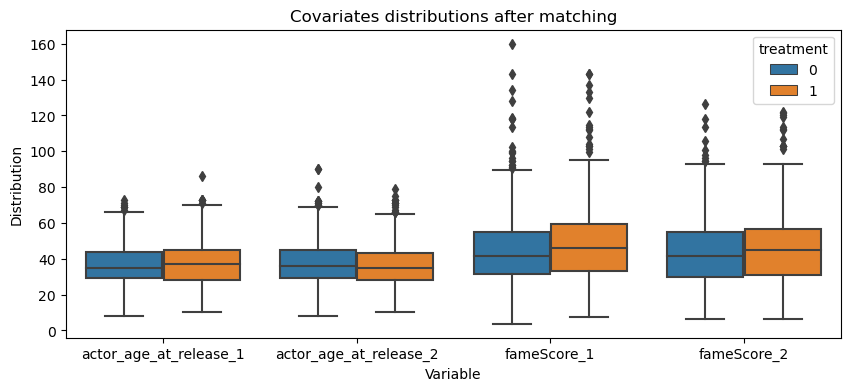

In [91]:
# Sanity check for age at film release for both actors and fameScrore for benefitting actor
matched_actor_feats['actor_age_at_release_1']=matched_actor_feats['actor_age_at_release_1'].astype(int)
matched_actor_feats['actor_age_at_release_2']=matched_actor_feats['actor_age_at_release_2'].astype(int)

plt.figure(figsize=(10,4))
sns.boxplot(data=matched_actor_feats[['actor_age_at_release_1','actor_age_at_release_2','fameScore_1', 'fameScore_2','treatment']]\
                    .melt(value_vars=['actor_age_at_release_1','actor_age_at_release_2','fameScore_1', 'fameScore_2'],
                          id_vars='treatment'),
            y='value',
            x='variable',
            hue='treatment')
plt.title('Covariates distributions after matching')
plt.ylabel('Distribution')
plt.xlabel('Variable');

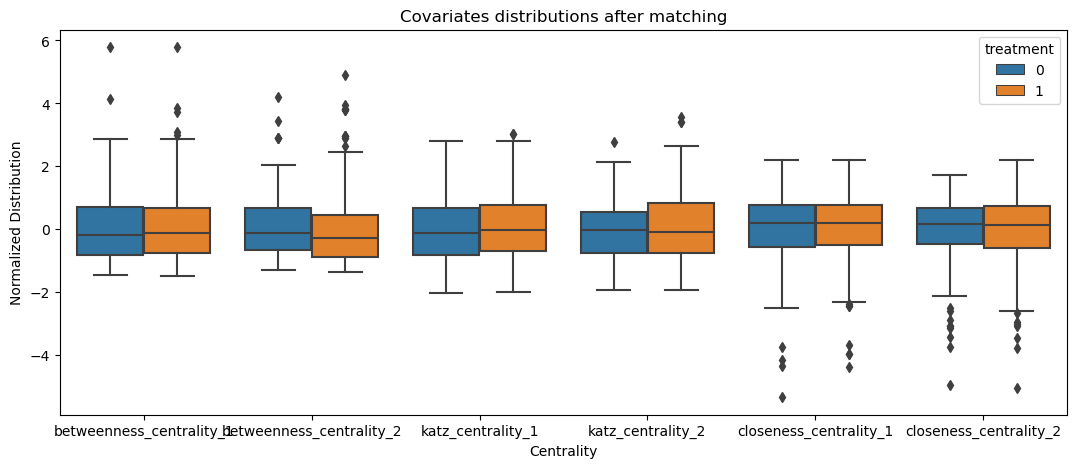

In [92]:
centrality_cols = ['betweenness_centrality_1','betweenness_centrality_2',
                   'katz_centrality_1','katz_centrality_2',
                   'closeness_centrality_1','closeness_centrality_2']
matched_actor_feats[centrality_cols] -= matched_actor_feats[centrality_cols].mean()
matched_actor_feats[centrality_cols] /= matched_actor_feats[centrality_cols].std()

plt.figure(figsize=(13,5))
sns.boxplot(data=matched_actor_feats[centrality_cols+['treatment']]\
                    .melt(value_vars=centrality_cols,
                          id_vars='treatment'),
            y='value',
            x='variable',
            hue='treatment')
plt.title('Covariates distributions after matching')
plt.ylabel('Normalized Distribution')
plt.xlabel('Centrality');

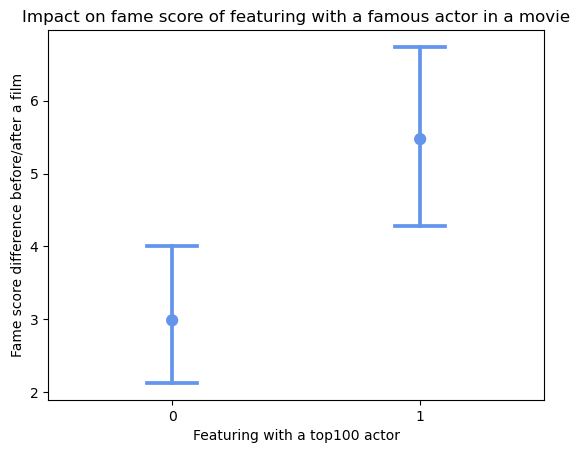

In [93]:
sns.pointplot(data=matched_actor_feats, x='treatment', y='fameScore_diff', color='cornflowerblue', 
              linestyles='none', capsize=0.2)#err_kws={'linewidth': 1}
plt.title('Impact on fame score of featuring with a famous actor in a movie')
plt.ylabel('Fame score difference before/after a film')
plt.xlabel('Featuring with a top100 actor');

In [94]:
stats.ttest_ind(matched_actor_feats.query('treatment==False')['fameScore_diff'].values, 
                matched_actor_feats.query('treatment==True')['fameScore_diff'].values)

TtestResult(statistic=-3.1500477538682445, pvalue=0.0016970632130285652, df=752.0)

### 2.2 Past genres Analysis

Here, we would like to study the relation between the number of genres an actor played in and its fame score

In [ ]:
def get_genre_diversity(df):
    '''
    This function returns the number of different past different genres assigned to movies an actor 
    played in before.
    '''
    df = df.sort_values('release_date')
    return pd.DataFrame({'wikiID':df['wikiID'].values,
                         'genre_diversity':[len(np.unique(np.hstack(df.iloc[:i+1]['genre'].values)))
                                            for i in range(df.shape[0])]})

# compute a dataframe with actor informations for each film with fame and number of past genres
actor_genres = cmu_character[['wikiID','actor_name','freebase_actorID','fameScore','release_date']] \
                            .merge(cmu_movies[['wikiID','genre']])

actor_genres['genre'] = actor_genres['genre'].apply(lambda x : x[:3]) #keep only the 3 main genres

actor_genres = actor_genres.merge(actor_genres.groupby('freebase_actorID').apply(get_genre_diversity)\
                                                                          .reset_index(level=0),
                                  on=['freebase_actorID','wikiID'])
actor_genres.sample(5)

Let's now use a scatter plot between the genre diversity and the fame score, adding the best fitting line.

In [ ]:
# we use a sample from the dataframe for clarity purposes
sns.lmplot(data=actor_genres.sample(1000), x='genre_diversity', y='fameScore')
plt.title('Fame score based with number of past genres played in')
plt.xlabel('Genre diversity')
plt.ylabel('Fame score')
plt.show()

We can now compute a linear regression model to see if there is a significant relation between the genre diversity and the fame score.

In [ ]:
mod = smf.ols(formula='fameScore ~ genre_diversity', data=actor_genres)
res = mod.fit()

print(res.summary())

Using statsmodels package we fit a line to the data and find a coefficient of 0.0119 for the genre diversity with a p-value rejecting the null hypothesis. This motivates further analysis to assess wether or not we only observe a correlation rather than a causation. In case of causality, it would mean that the actor should play in a broad genre of movies to maximize its fame score.

### 2.2 Persona Analysis

The goal in this part is to obtain the relation between actor characteristics, the kind of characters they play (persona) and the fame score increase or decrease. To do that we first only select in the table the rows with full usefull data for this analysis and we look at the distribution of the fame score difference.

In [ ]:
# We retrieve the fame score difference for each actor at every film
cmu_chara_persona = cmu_character.merge(actor_fame_diff,on=['wikiID','freebase_actorID','release_date'])
cmu_chara_persona = cmu_chara_persona[['actor_gender','actor_height','actor_ethnicity','actor_age_at_release',
                                       'persona','fameScore_diff']].copy()
cmu_chara_persona.dropna(inplace=True)

#We transform the persona dtype to str because we don't want to interpret it as numbers but as a class name
cmu_chara_persona['persona'] = cmu_chara_persona['persona'].apply(lambda x : str(int(x)))

plt.hist(cmu_chara_persona['fameScore_diff'],density=True,bins=50)
plt.title('Fame Score Difference Density')
plt.xlabel('Fame Score Difference')
plt.ylabel('Density')
plt.show()

We can see that we have in average a little increase in fame when an actor appears in a movie, which makes sense.

Now we want to look at how the personas and ethnicity are distributed among the actors. If we see that we have personas or ethnicity that are not present enough we will get rid of them since they will not be significant enough for our analysis.

In [ ]:
persona_count = cmu_chara_persona[['persona','actor_ethnicity']]\
                .groupby('persona',as_index=False).count().rename(columns={'actor_ethnicity':'count'})
persona_count.sort_values('count',inplace=True,ascending=False)

ethnicity_count = cmu_chara_persona[['persona','actor_ethnicity']]\
                  .groupby('actor_ethnicity',as_index=False).count().rename(columns={'persona':'count'})
ethnicity_count.sort_values('count',inplace=True,ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
fig.suptitle('Persona and ethnicity distribution')

axes[0].bar(persona_count['persona'],persona_count['count'])
axes[1].bar(ethnicity_count['actor_ethnicity'],ethnicity_count['count'])

for ax in axes:
    ax.set_xticks([])

axes[0].set_xlabel('persona')
axes[1].set_xlabel('ethnicity')
axes[0].set_ylabel('number of entity')
axes[1].set_ylabel('number of entity');

In [ ]:
# We decide to take only the ones with more than 200 entities
persona_count = persona_count.query('count >= 200')
ethnicity_count = ethnicity_count.query('count >= 200')

# We keep only the rows with persona and the ethnicity we're interested in 
cmu_chara_persona = cmu_chara_persona.merge(persona_count['persona'],on='persona',how='right')
cmu_chara_persona = cmu_chara_persona.merge(ethnicity_count['actor_ethnicity'],on='actor_ethnicity',how='right')

cmu_chara_persona.info()

For the further analysis, the '/' in the actor_ethnicity id will cause problem to the algorithm. We decide to change them to a code_number here.

In [ ]:
ethnicity_code_nbr = ethnicity_count['actor_ethnicity'].reset_index(drop=True)\
                                                        .reset_index().rename(columns={'index':'ethni_nbr'})

cmu_chara_persona = cmu_chara_persona.merge(ethnicity_code_nbr,on='actor_ethnicity')\
                                     .drop(columns='actor_ethnicity')
cmu_chara_persona.sample(5)

We can now separate the categorical values with the get_dummies function. This correspond to a one hot encoding of the categorical values.

In [ ]:
cmu_chara_persona_analysis = pd.get_dummies(cmu_chara_persona,columns=['persona','actor_gender','ethni_nbr'])

Finally we can perform a linear regression to assess the impact of each actor characteristic on the fame score difference.

In [ ]:
# This code is used to define the formula for the regression
columns = cmu_chara_persona_analysis.columns.tolist()[3:]
formula = 'fameScore_diff ~ actor_age_at_release + actor_height'

for col in columns:
    formula += ' + C('+col+')'

In [ ]:
mod = smf.ols(formula=formula, data=cmu_chara_persona_analysis)
res = mod.fit()

colors = ['cornflowerblue' if p < 0.05 else 'tomato' for p in res.pvalues]

res.params.plot.bar(figsize=(15,5) ,color=colors)

significant_patch = mpatches.Patch(color='cornflowerblue', label='p < 0.05 (significant)')
not_significant_patch = mpatches.Patch(color='tomato', label='p >= 0.05 (not significant)')
plt.legend(handles=[significant_patch, not_significant_patch])

plt.title('Regression coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.show()

In [ ]:
print(res.summary())

When conducting linear analysis, it is essentially comparing means of different groups represented by the categorical variables. Hence, we see that the average fame score increase greatly varies depending on the actor's characteristics and persona played. However, we observe that many of these variables have a coefficient for which we cannot reject the null hypothesis under the 0.05 threshold. We will further analyse to better differentiate subgroups in which the fame score increase is significantly different.